In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import fileinput
import os

In [51]:
broad_files = sorted(glob.glob('./my_source/bkg_corr_bin100/acis*b.lc.txt'))
soft_files = sorted(glob.glob('./my_source/bkg_corr_bin100/acis*s.lc.txt'))
medium_files = sorted(glob.glob('./my_source/bkg_corr_bin100/acis*m.lc.txt'))
hard_files = sorted(glob.glob('./my_source/bkg_corr_bin100/acis*h.lc.txt'))
#bintime_files = sorted(glob.glob('./my_source/bkg_corr_bin100/*bintime.txt'))

all_files = np.stack((broad_files, soft_files, medium_files, hard_files), axis=1)

/tmp/ipykernel_567591/1448838125.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 10)) # Define the figure


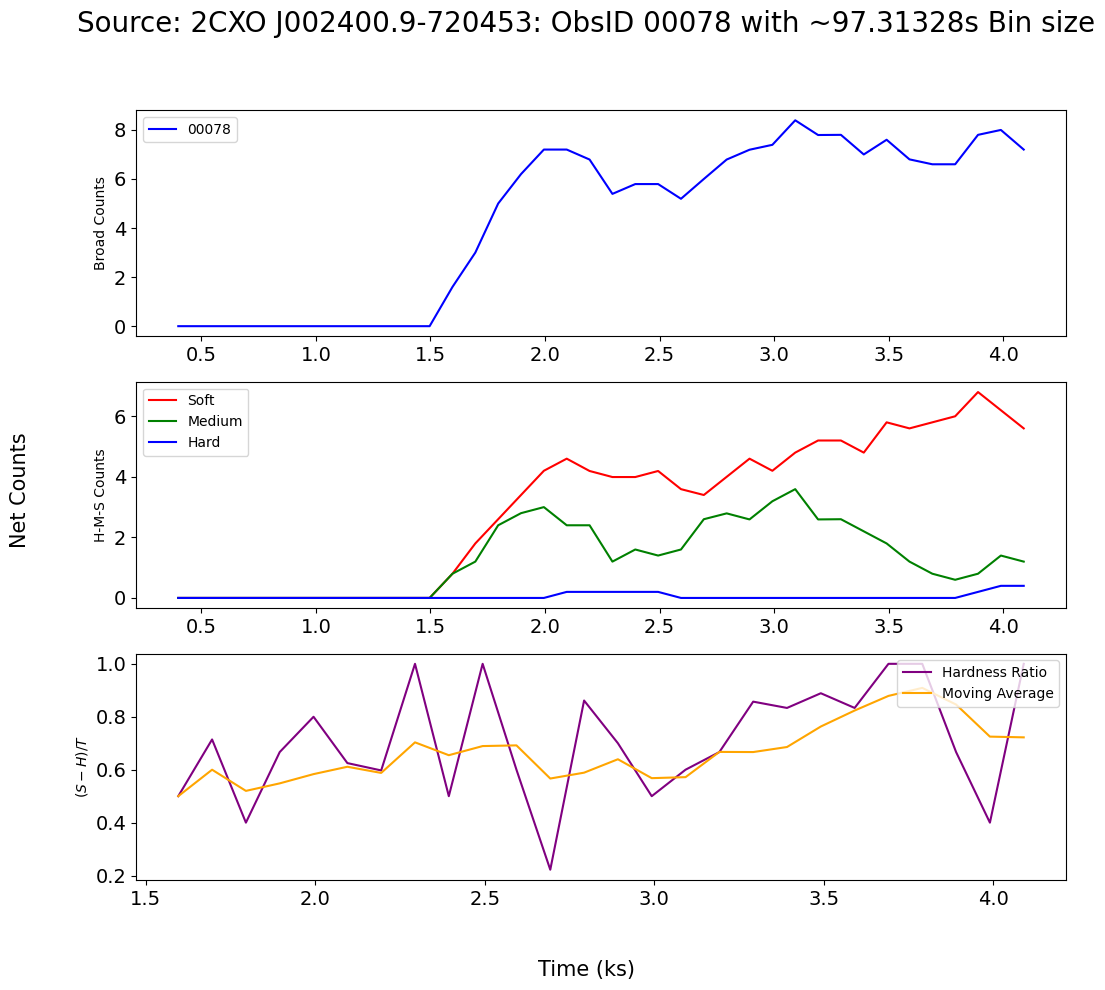

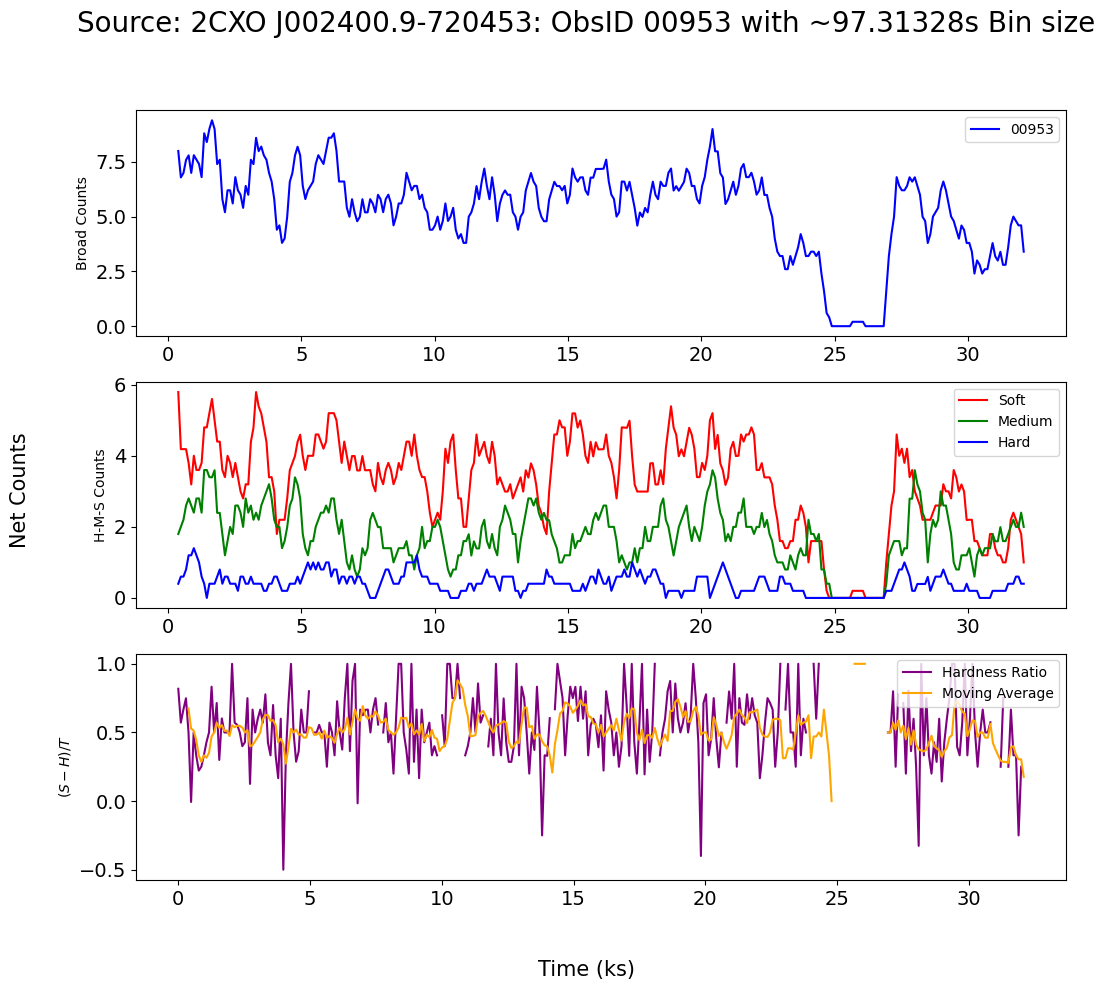

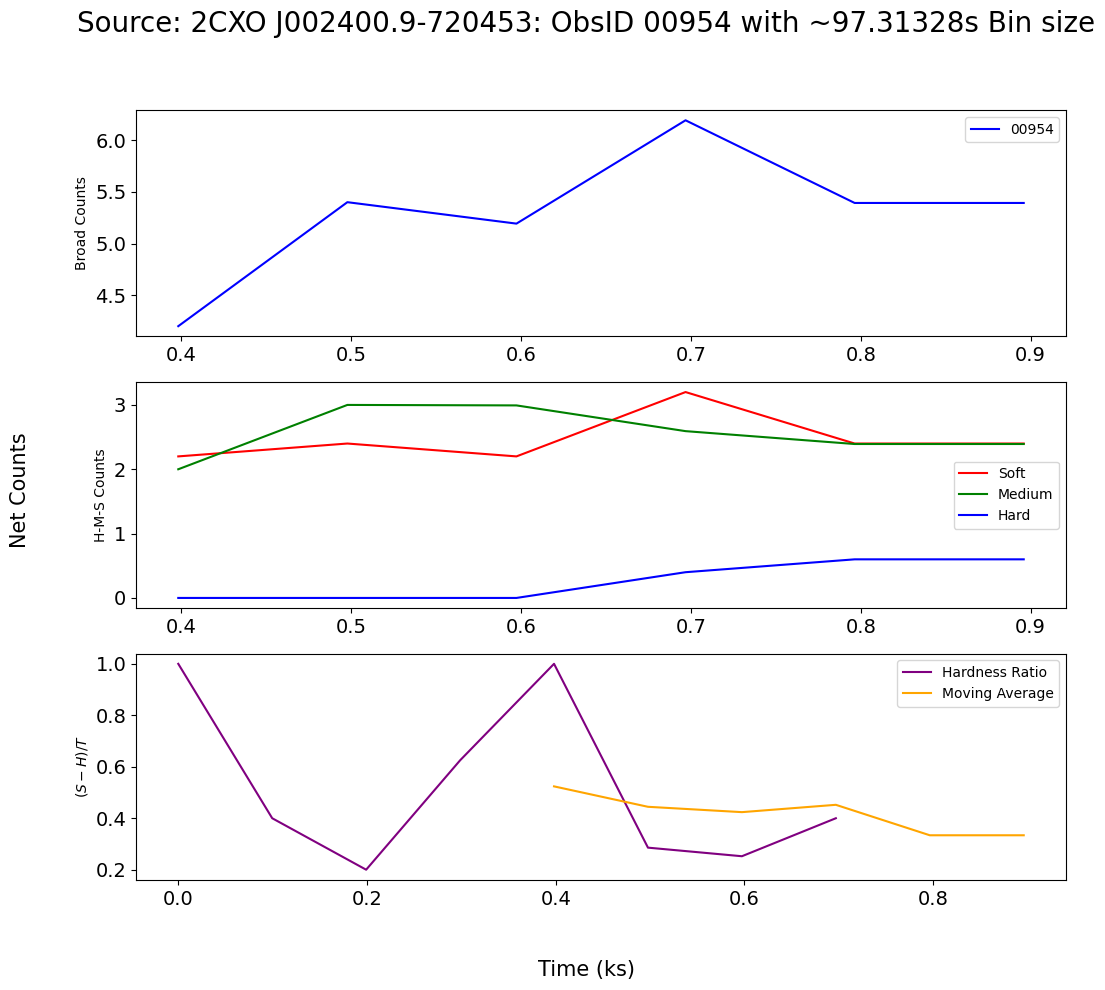

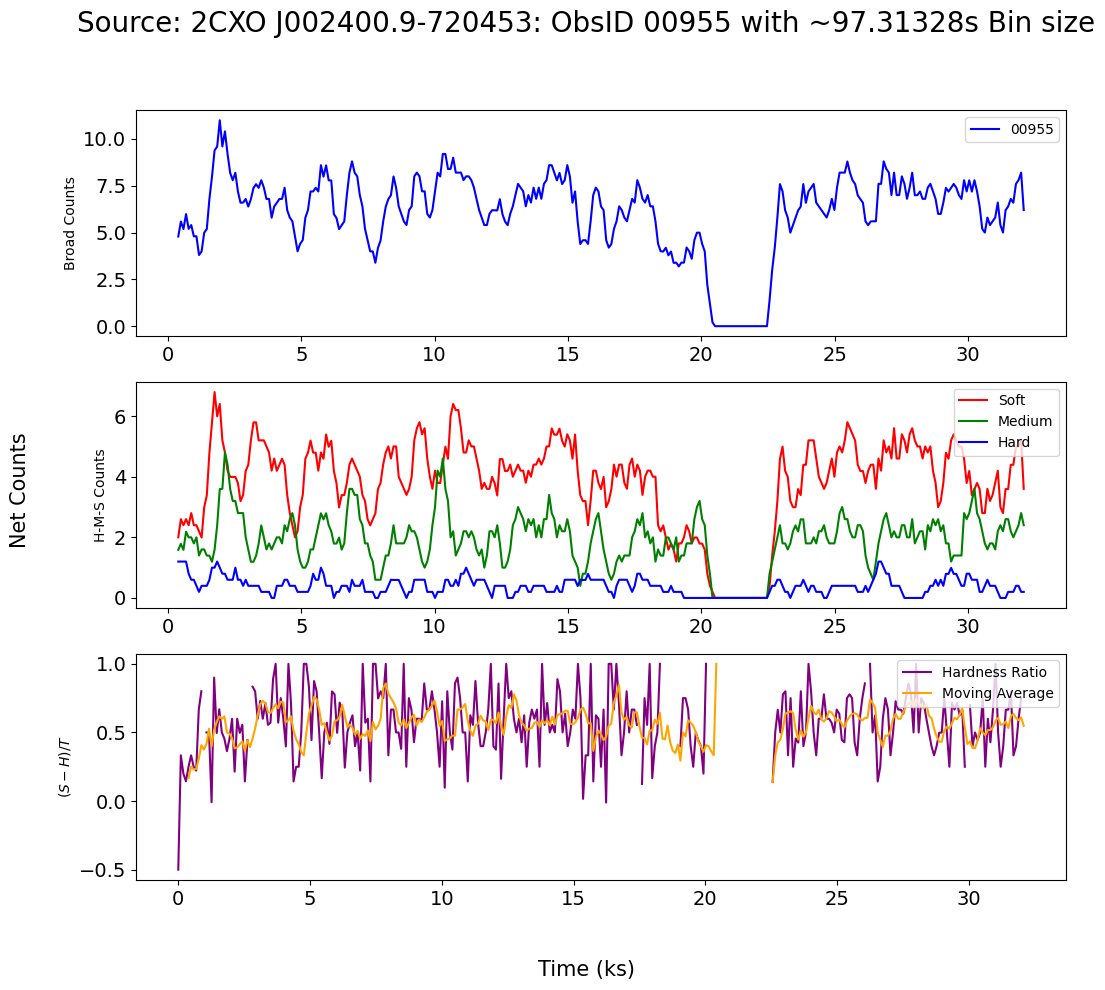

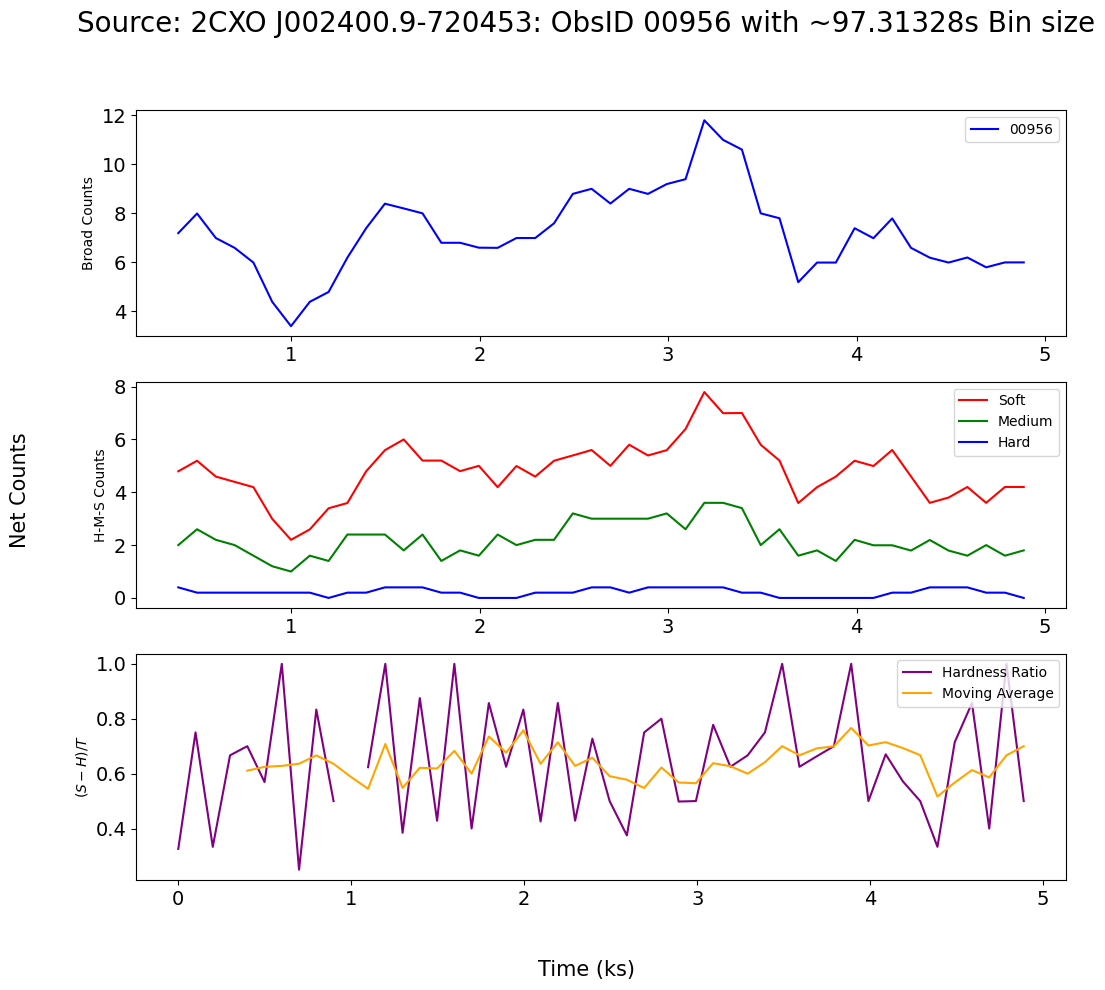

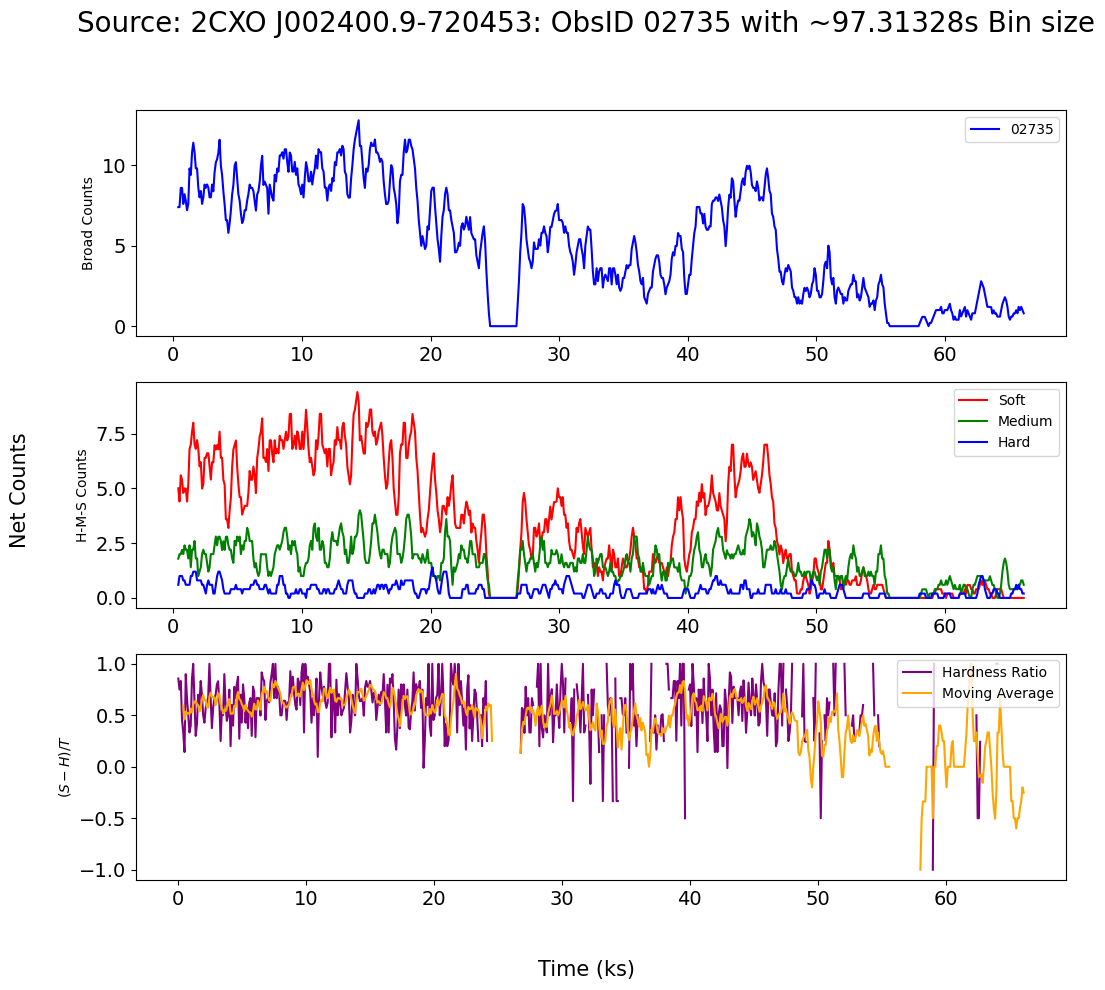

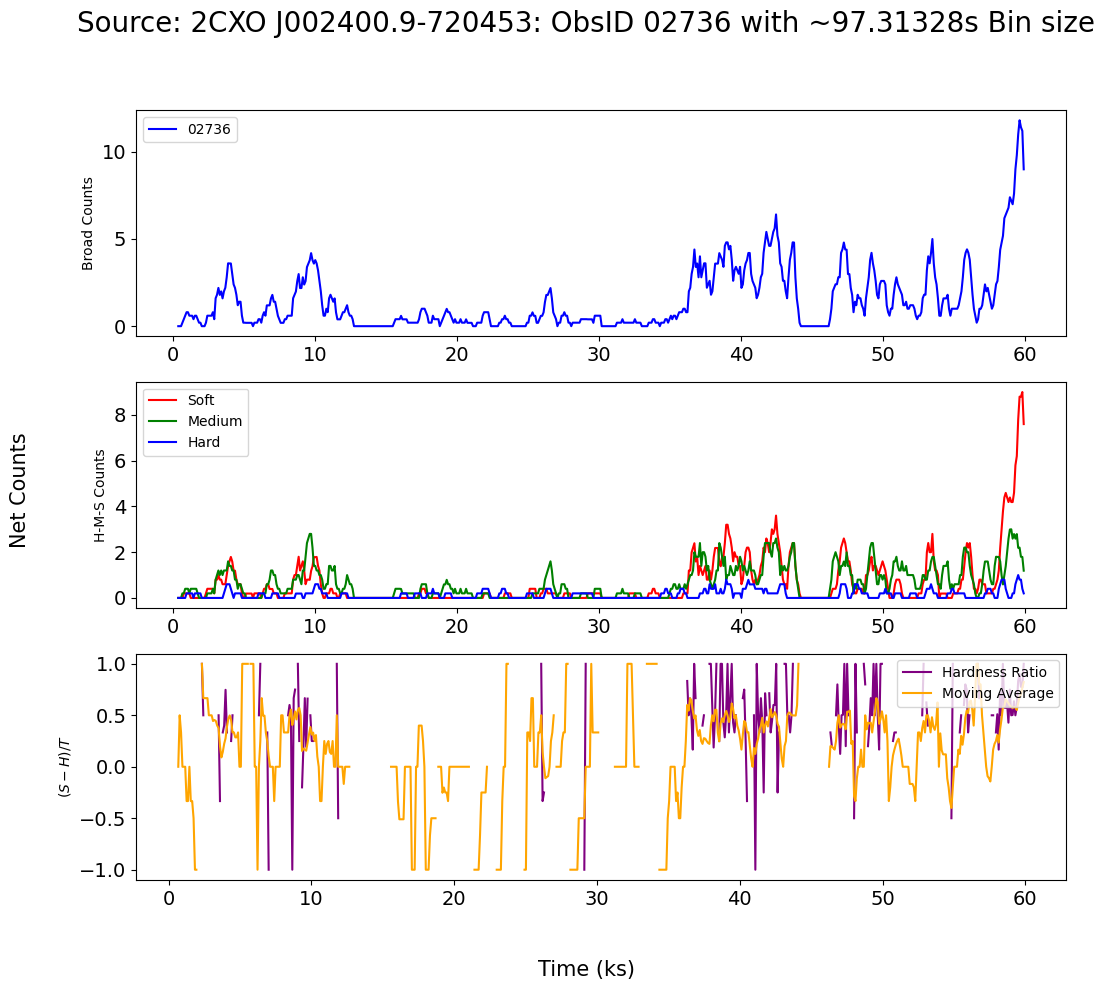

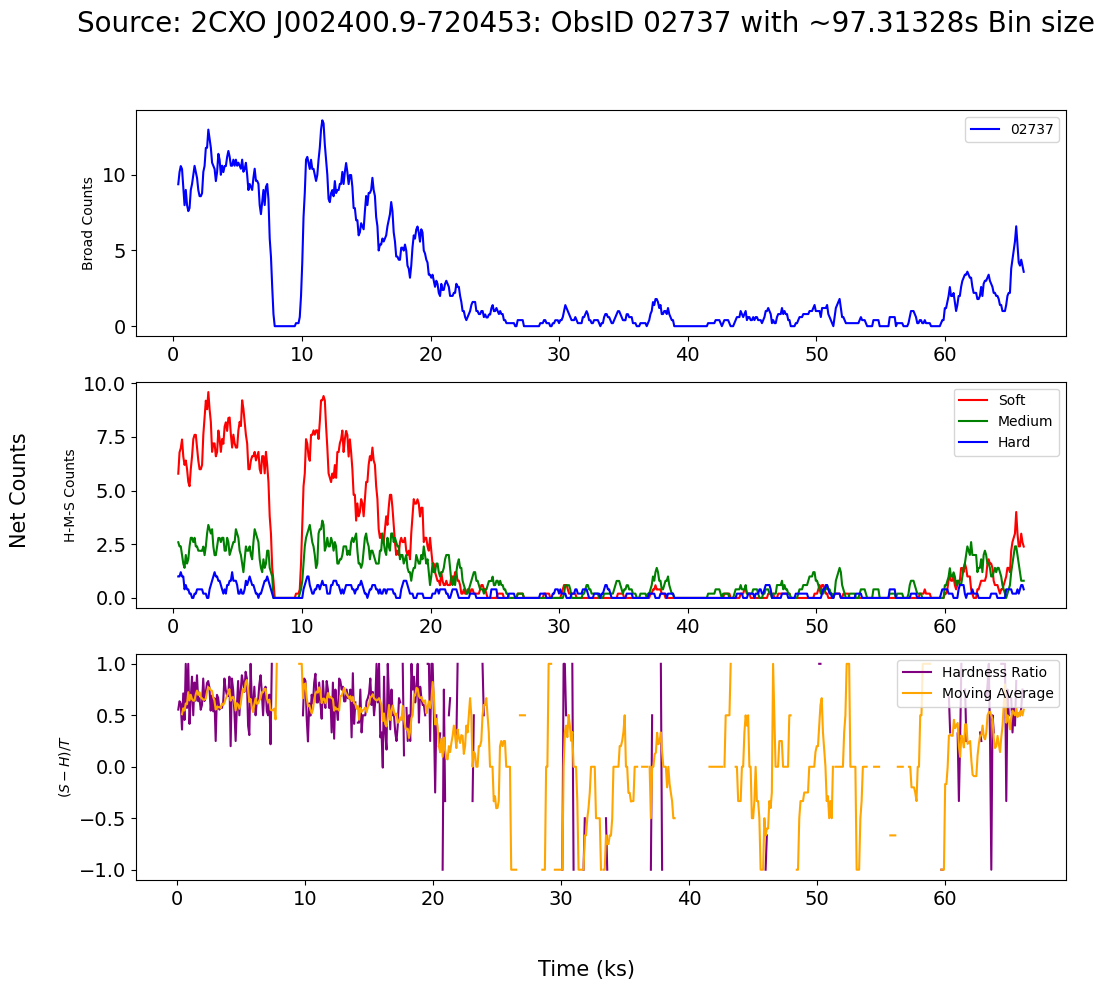

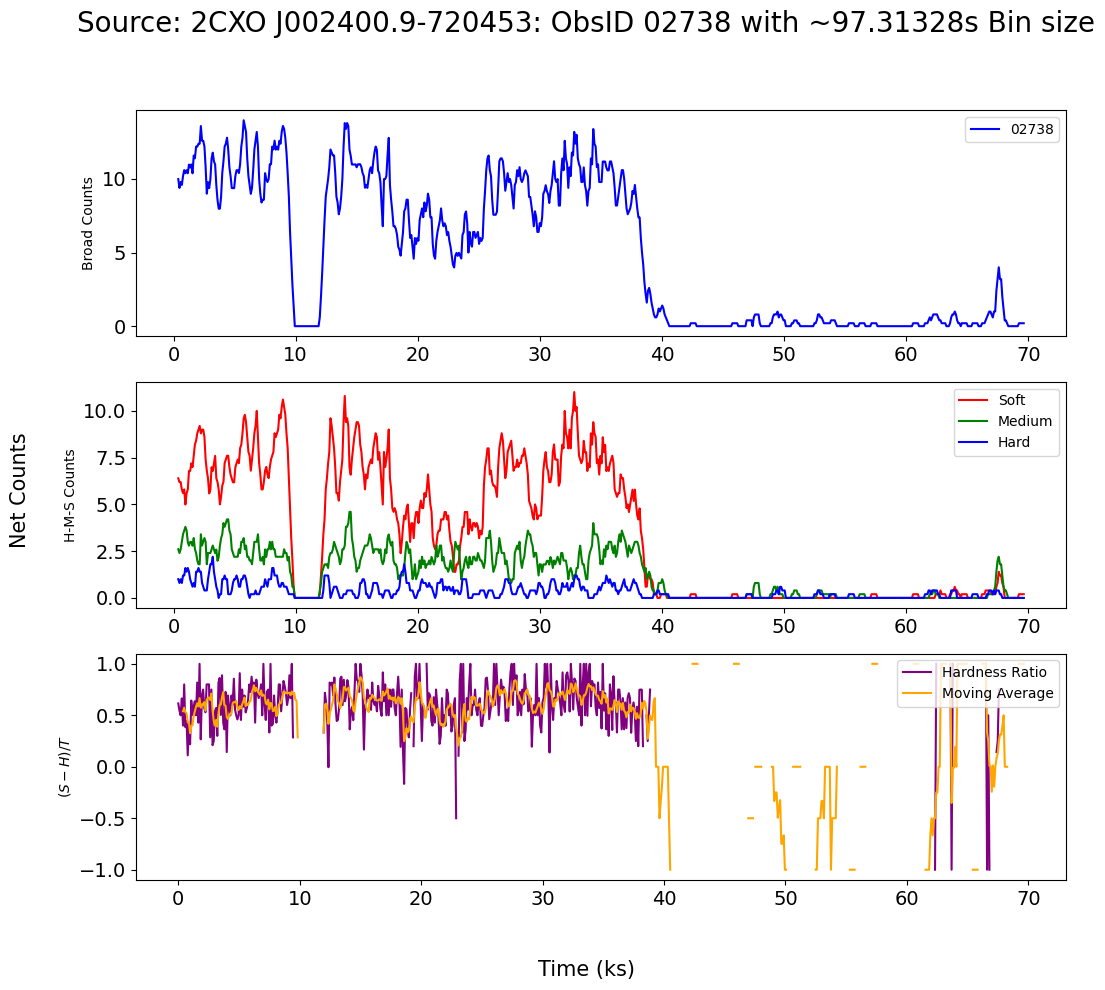

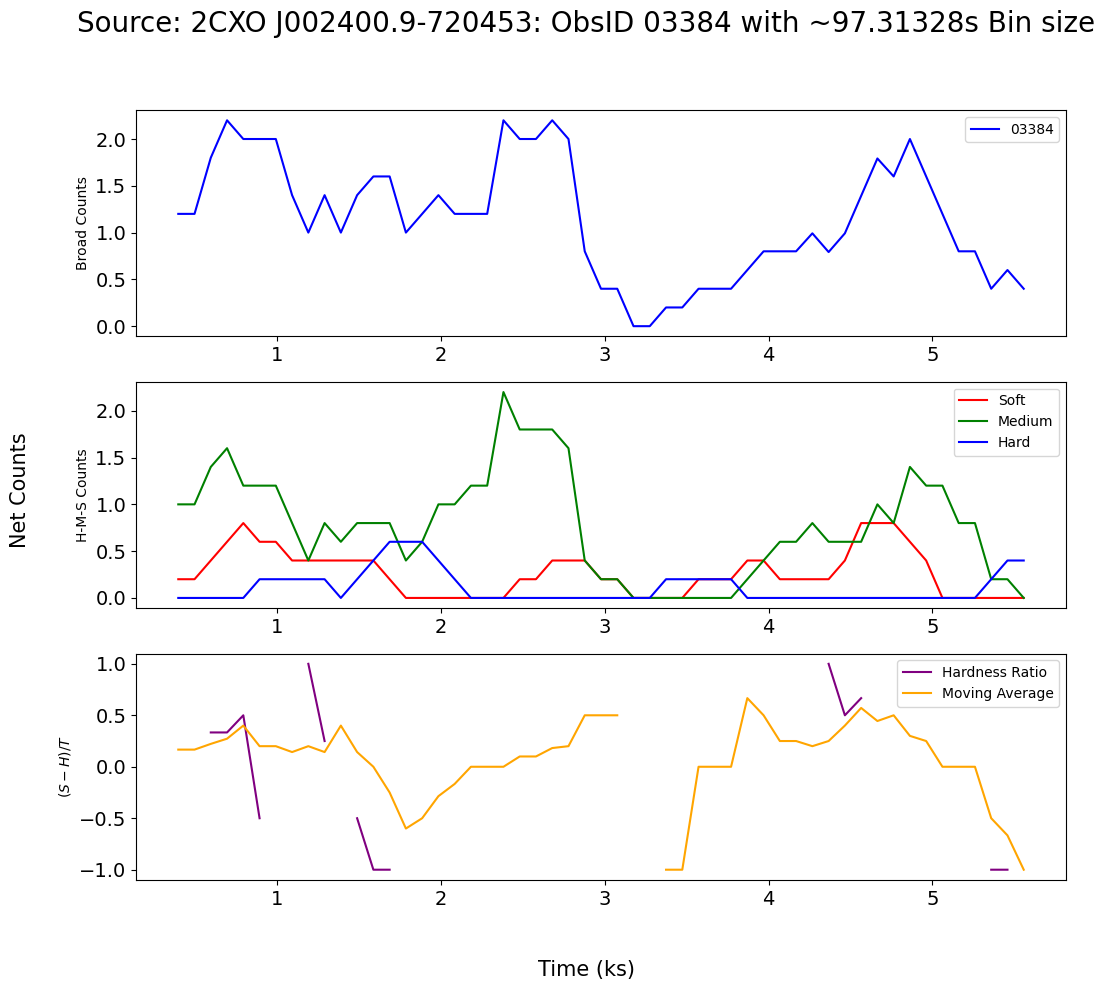

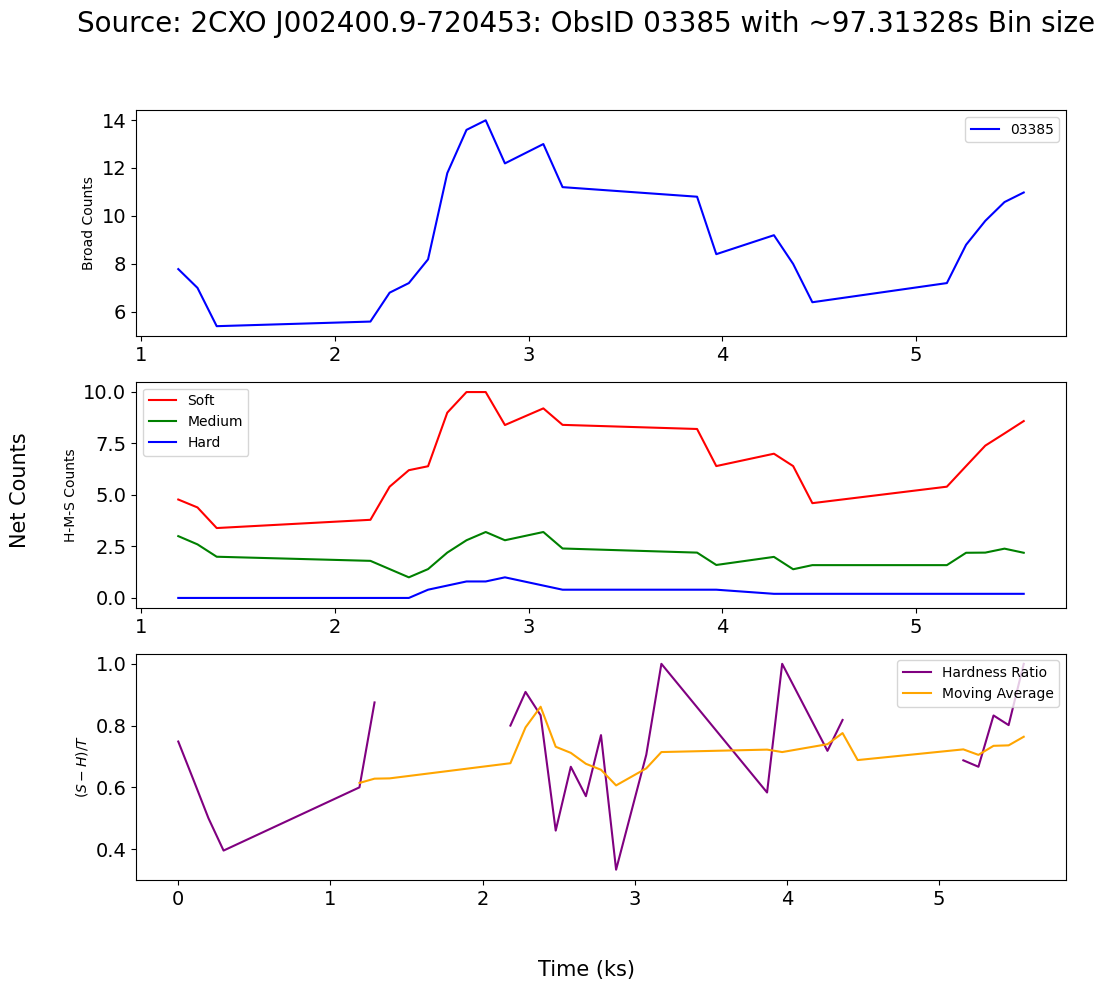

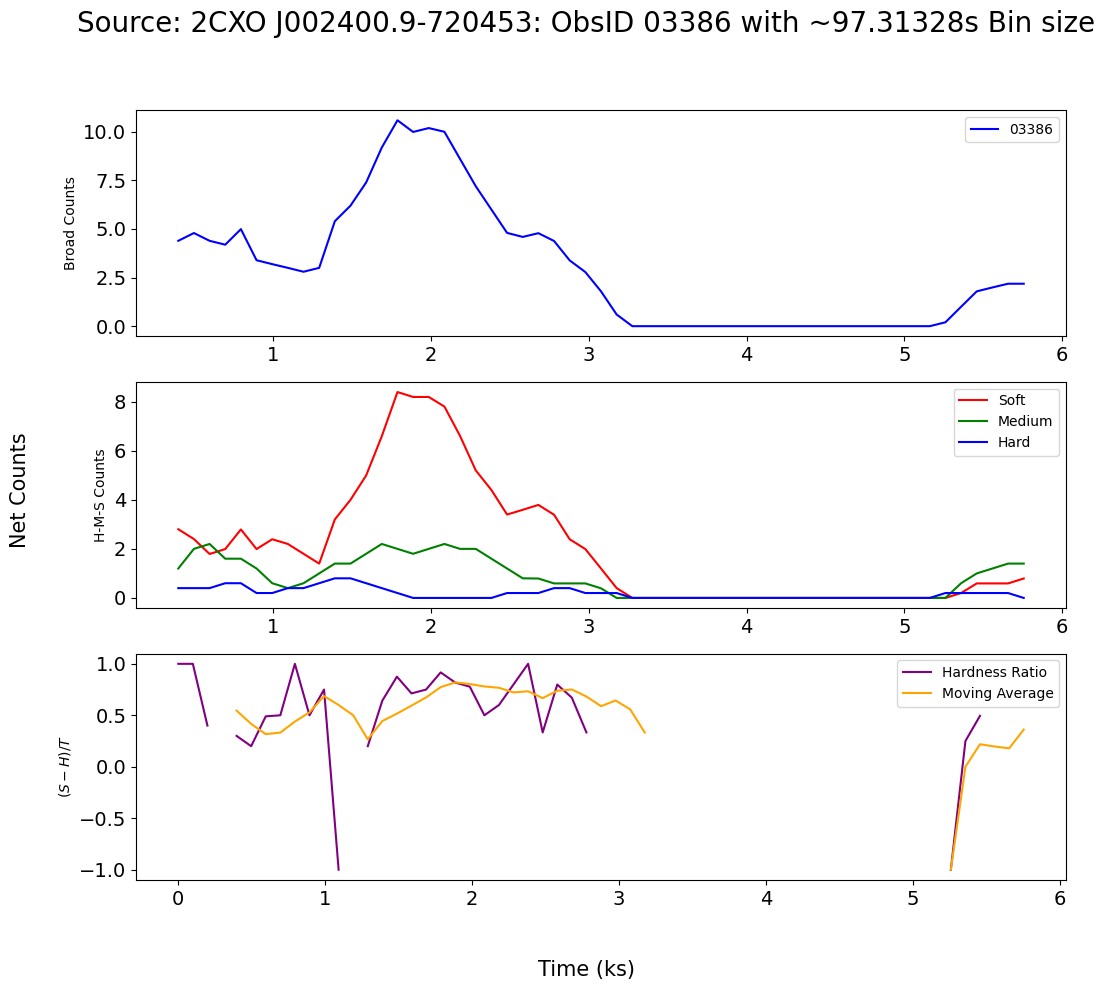

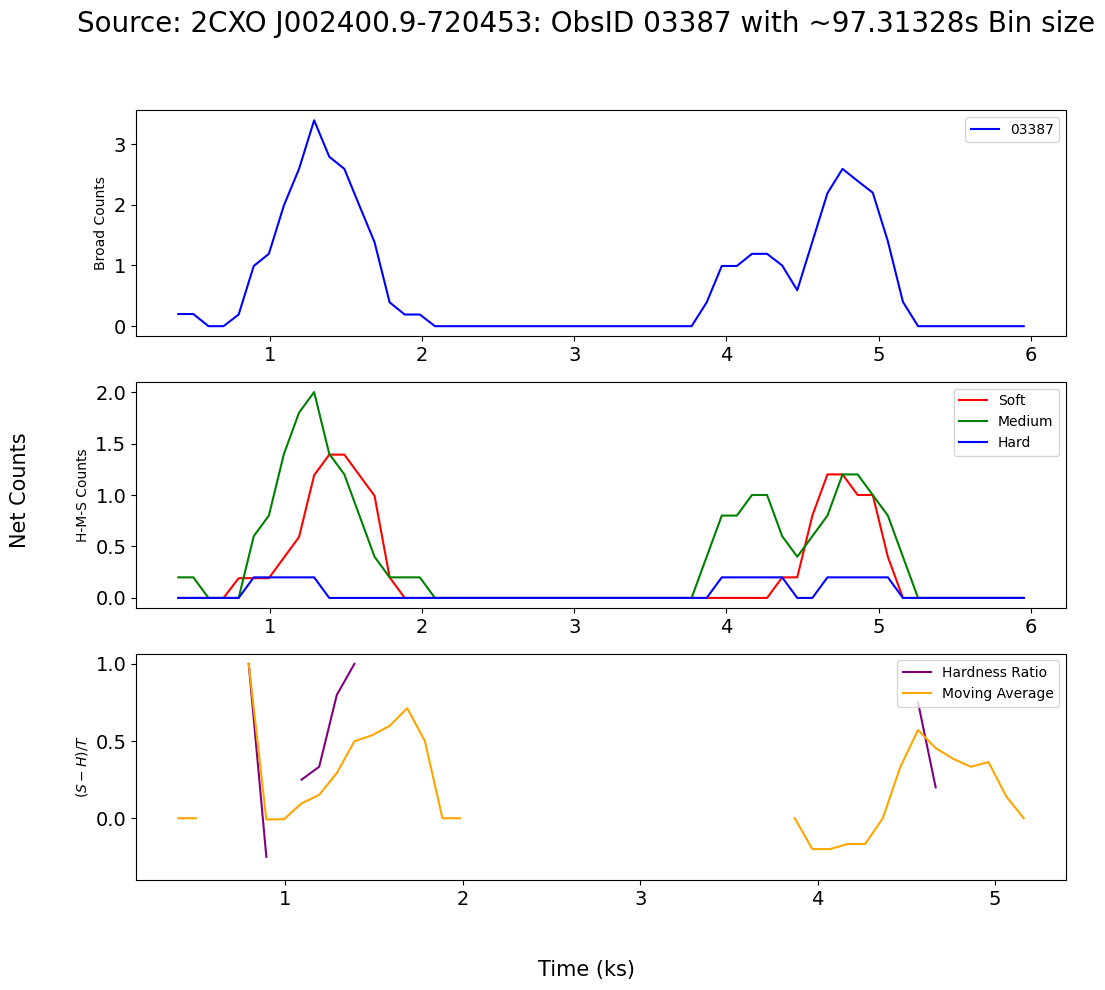

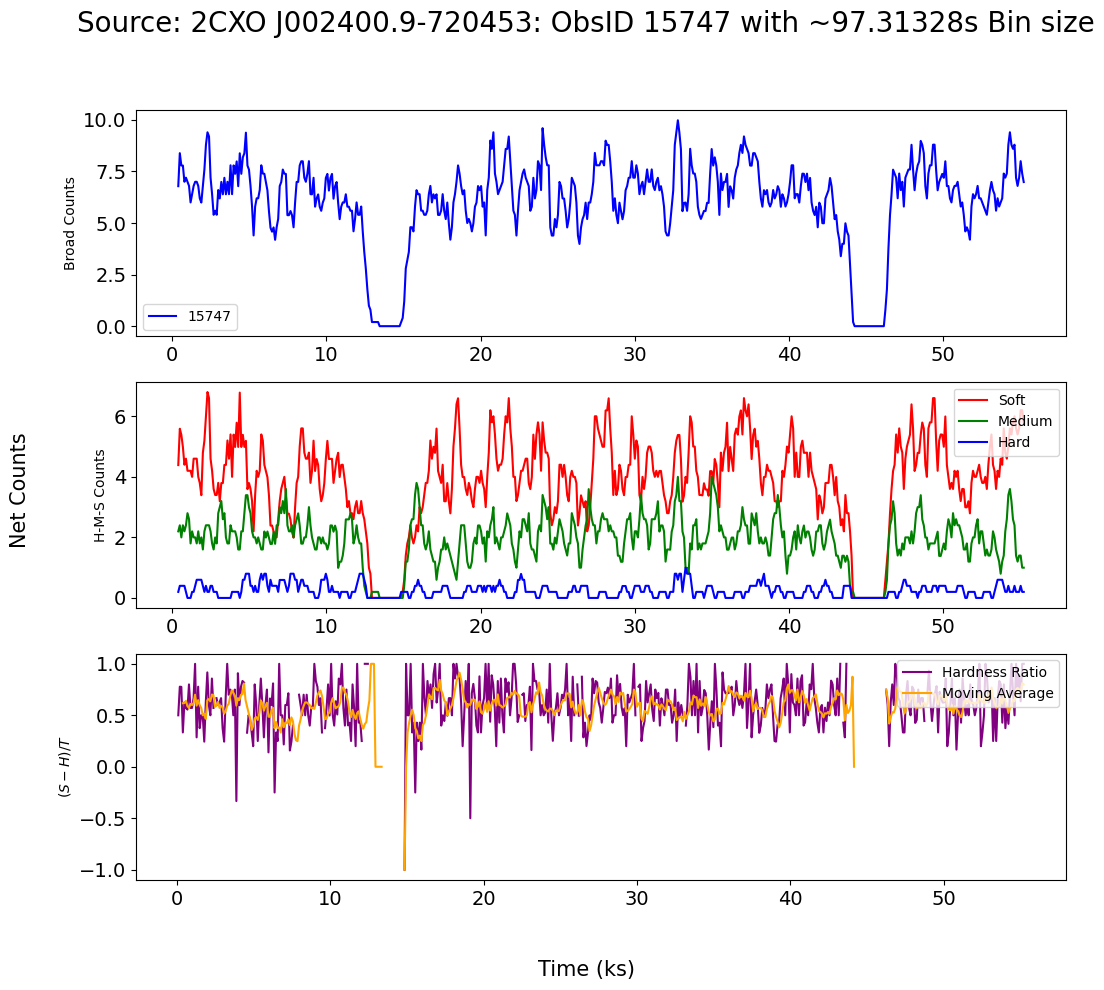

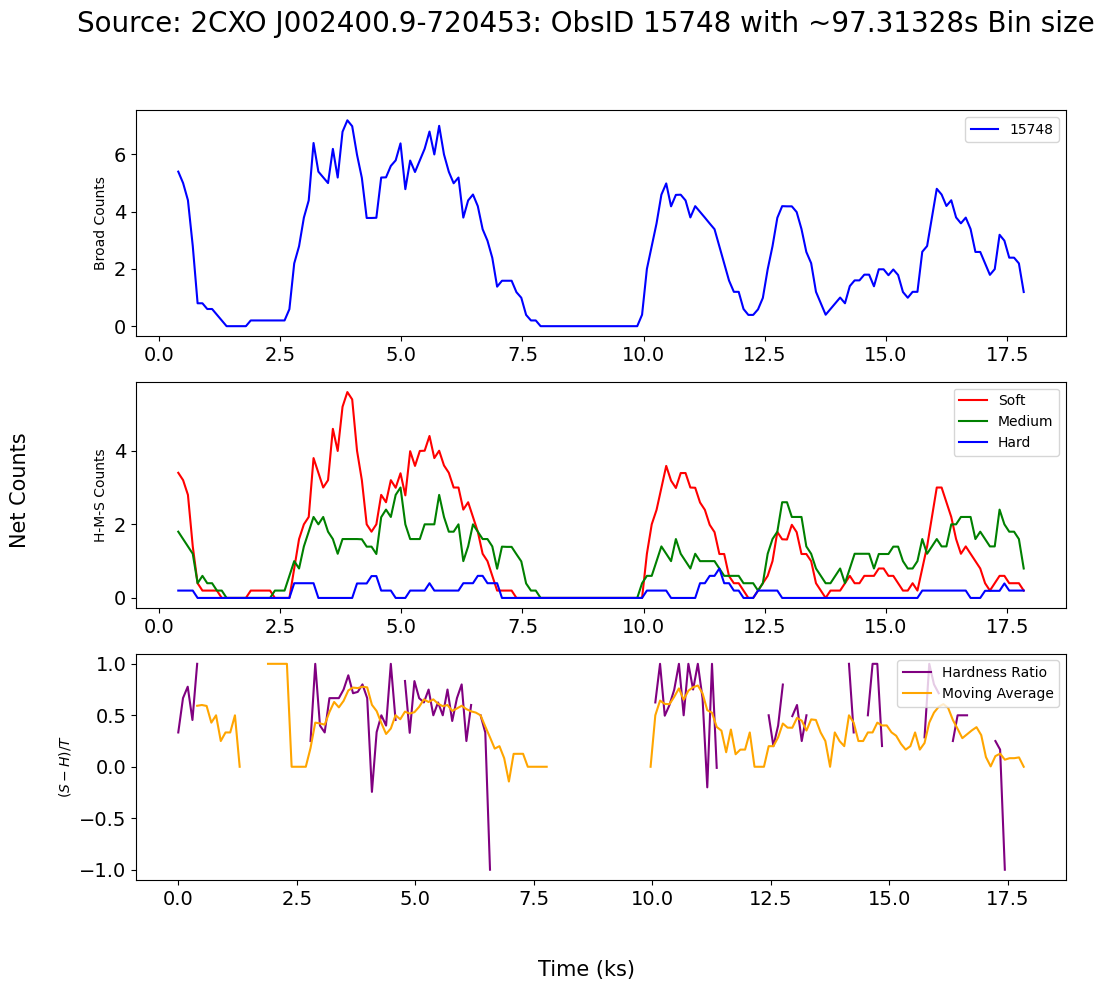

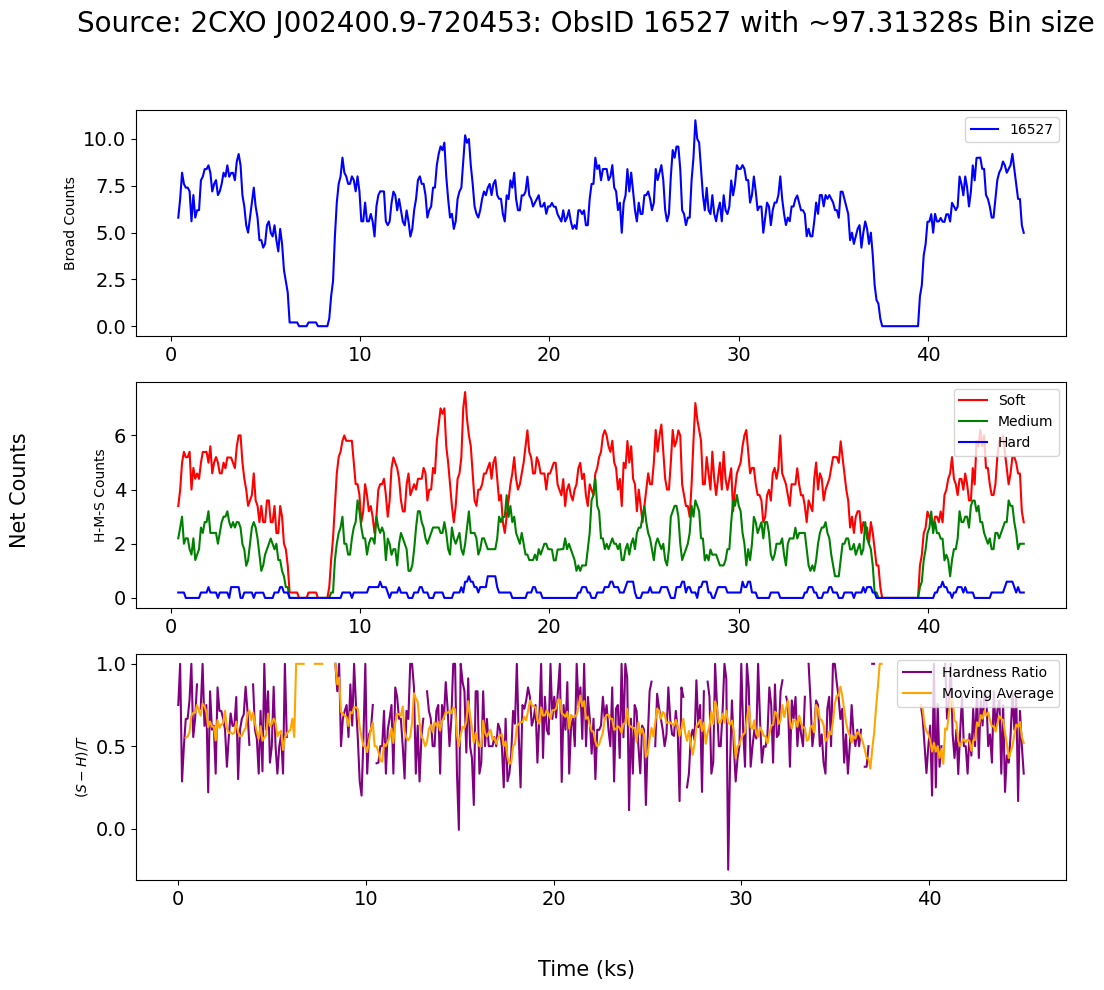

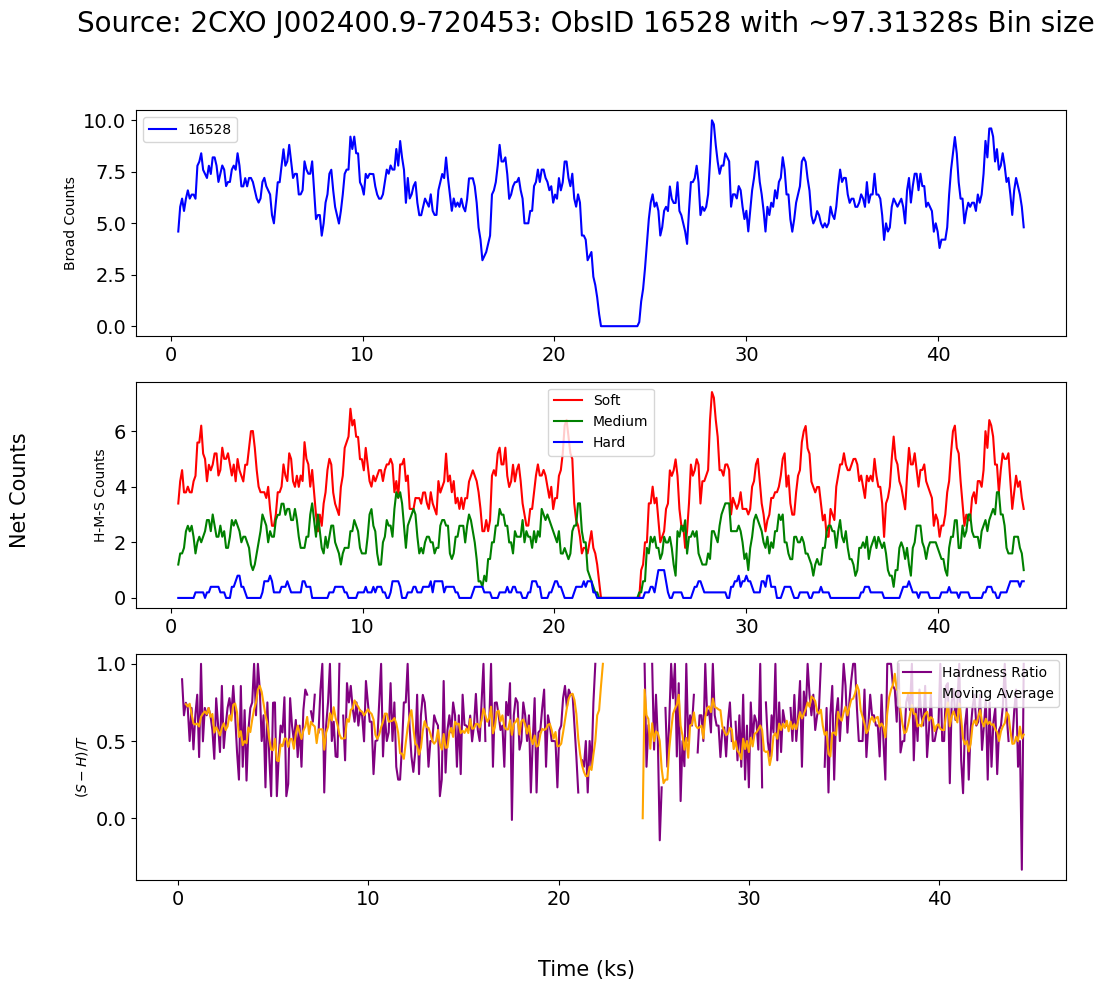

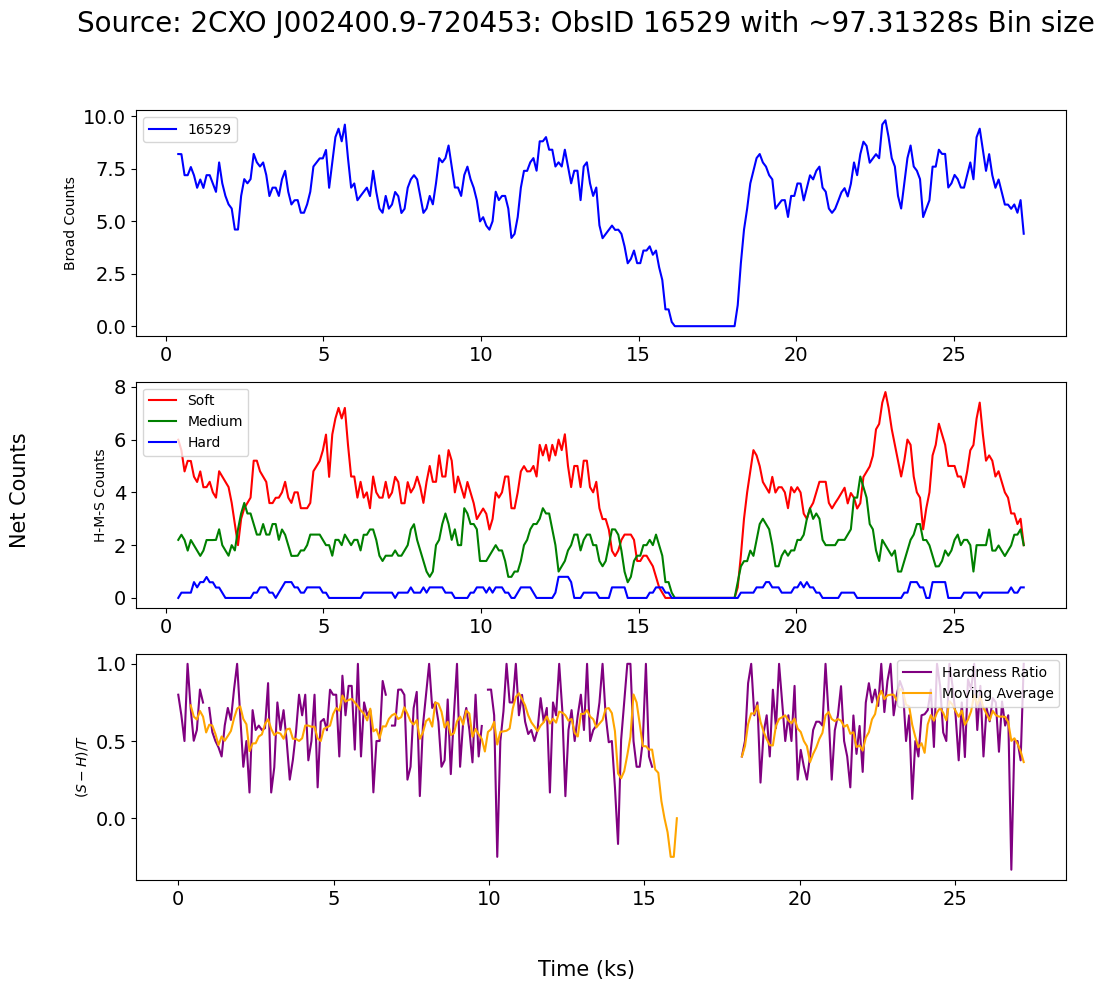

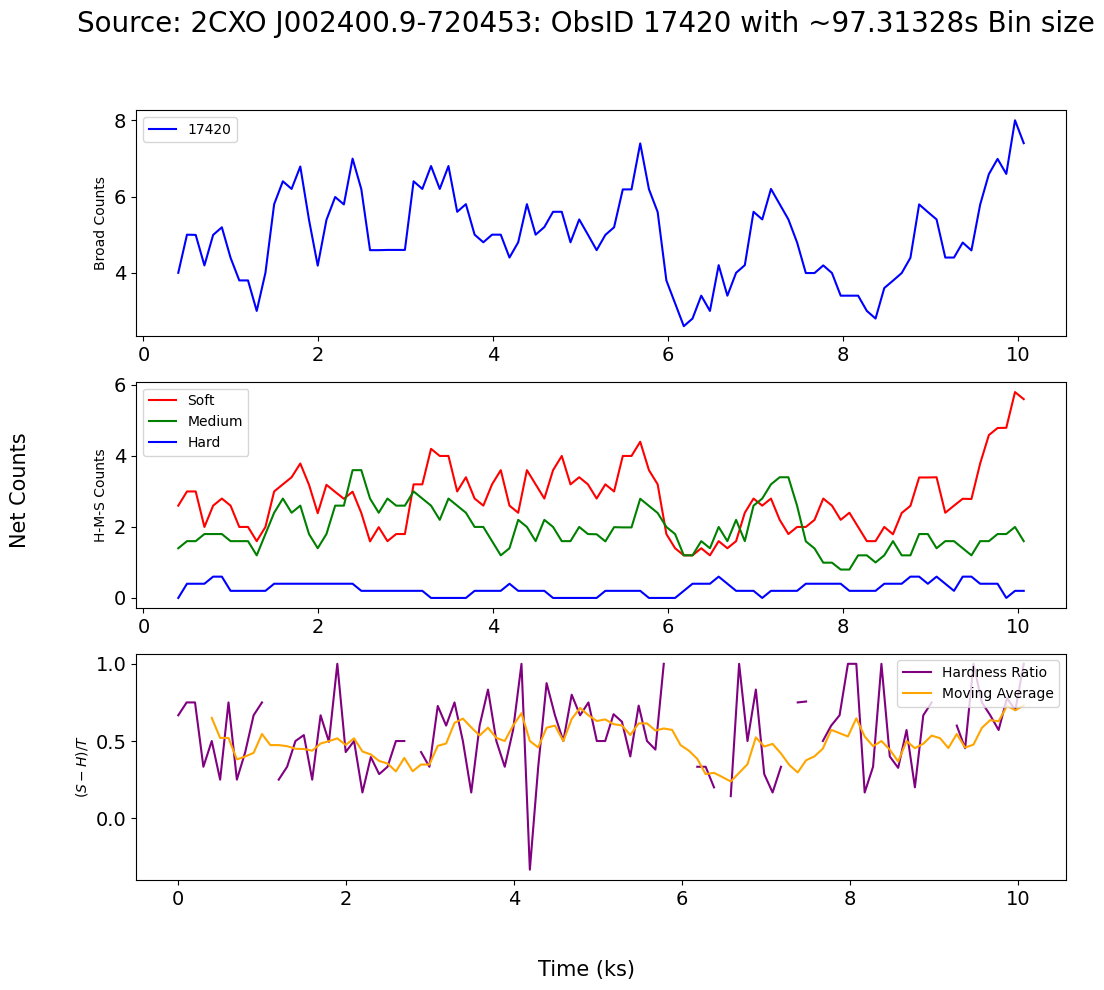

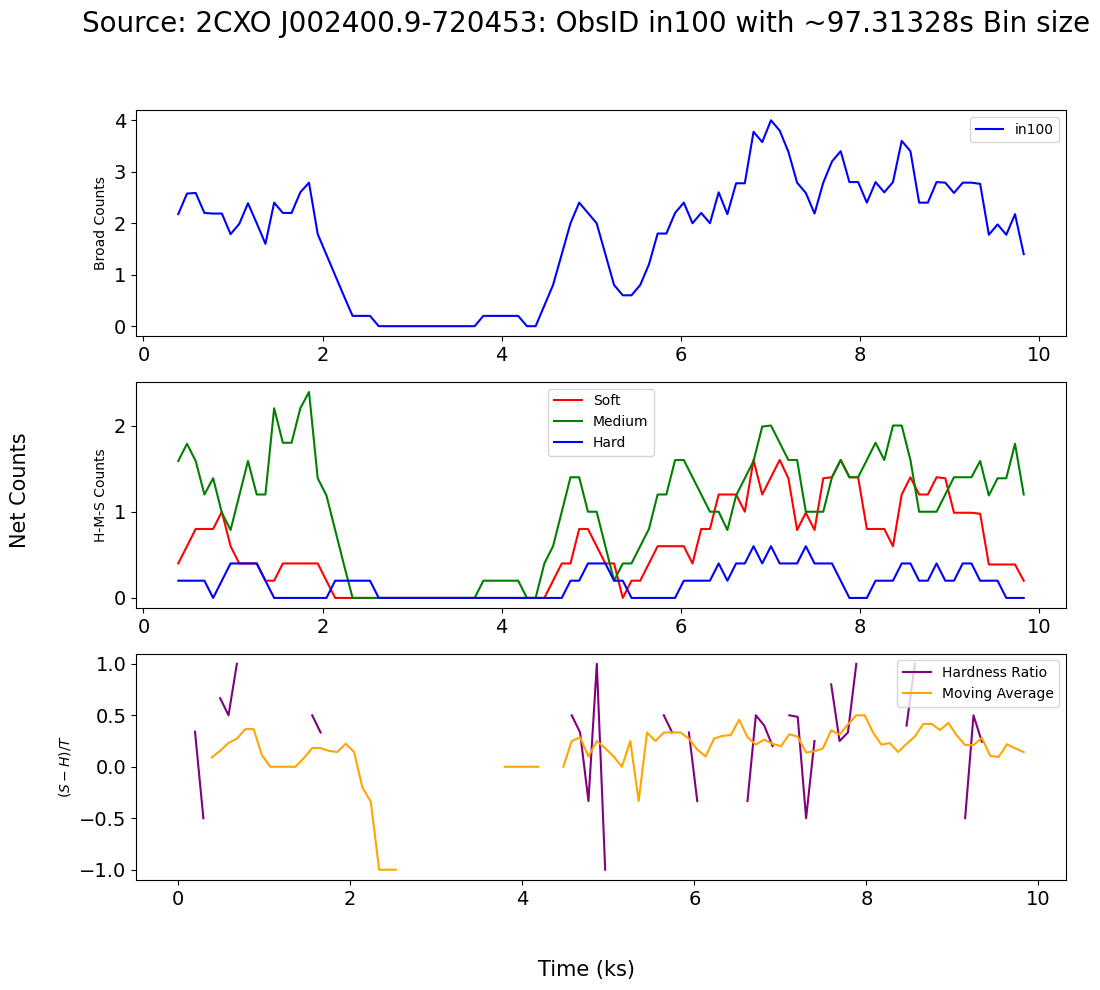

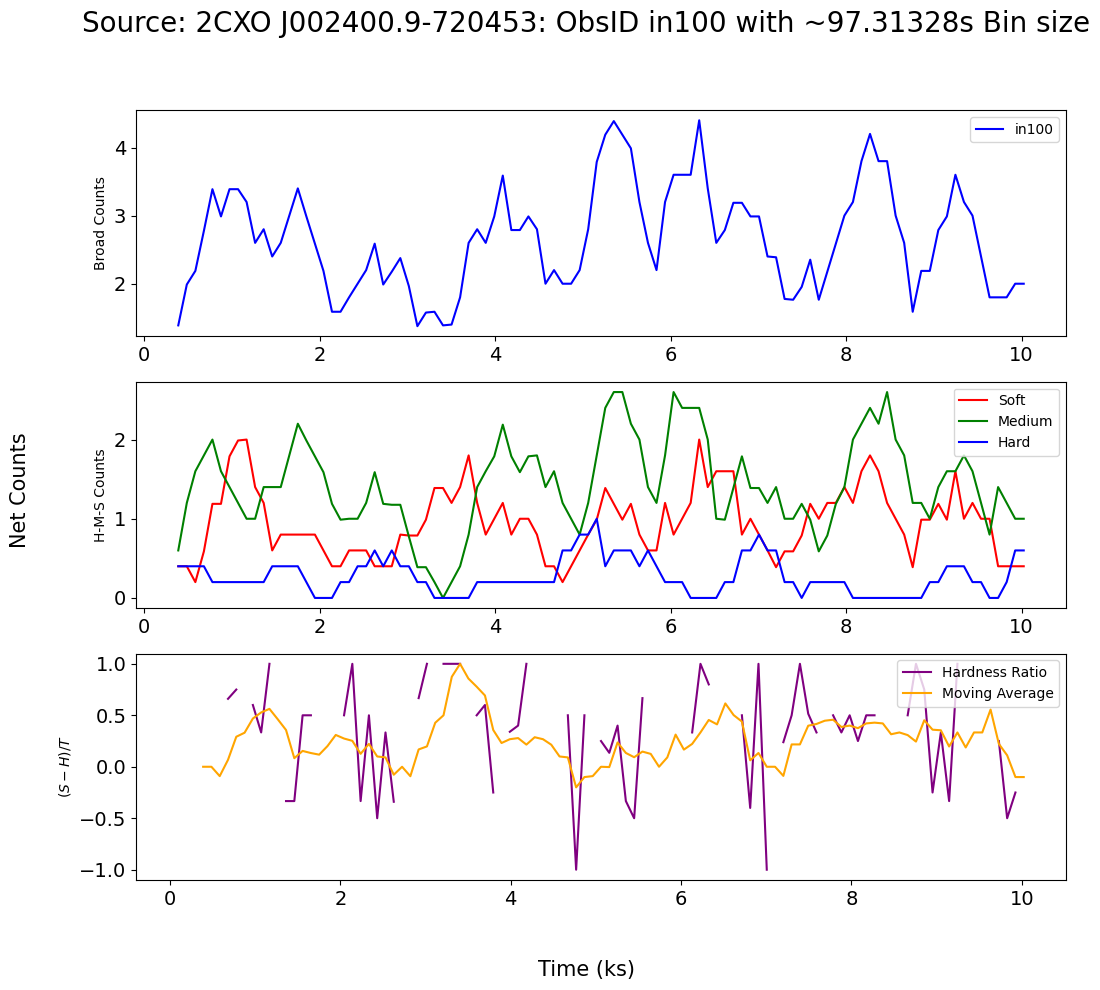

In [50]:
for file in all_files:
    broad_data = np.loadtxt(file[0])
    soft_data = np.loadtxt(file[1])
    medium_data = np.loadtxt(file[2])
    hard_data = np.loadtxt(file[3])
    #bintime = np.loadtxt(file[4])

    #obsid = file[0][39:44]
    obsid = file[0][-41:-36]

    data_stack = np.stack((broad_data, soft_data, medium_data, hard_data), axis=1)
#filter data for exposure=0 times
    filtered = []
    for idx, data_stack_i in enumerate(data_stack):
        array = data_stack[idx]
        if array[0][4] != 0:
            filtered.append(array)
    filtered_new = np.array(filtered)

    bd = filtered_new[:,0]
    sd = filtered_new[:,1]
    md = filtered_new[:,2]
    hd = filtered_new[:,3]
#change any negative net count values to 0
    bd[:,3][bd[:,3] < 0] = 0
    sd[:,3][sd[:,3] < 0] = 0
    md[:,3][md[:,3] < 0] = 0
    hd[:,3][hd[:,3] < 0] = 0

    min_time = bd[:,0].min()
    time_data = (bd[:,0] - min_time)/1000
#calculate current counts
    current = []
    current_count = 0
    for val in bd[:,3]:
        current_count += val
        current.append(current_count)

    soft_counts = sd[:,3]
    medium_counts = md[:,3]
    hard_counts = hd[:,3]

    total_counts = soft_counts+medium_counts+hard_counts

    small_constant = 1e-6
    window_size = 5

    df = pd.DataFrame({'Time': time_data, 'Broad': bd[:,3], 'Soft': soft_counts, 'Medium': medium_counts, 'Hard': hard_counts, 'Total': total_counts})
    df['Broad Rolling Average'] = df['Broad'].rolling(window_size).mean()
    df['Soft Rolling Average'] = df['Soft'].rolling(window_size).mean()
    df['Medium Rolling Average'] = df['Medium'].rolling(window_size).mean()
    df['Hard Rolling Average'] = df['Hard'].rolling(window_size).mean()
    df['Total Rolling Average'] = df['Total'].rolling(window_size).mean()
    
    df['Hardness Rolling Average'] = (df['Soft Rolling Average'] - df['Hard Rolling Average']) / (df['Total Rolling Average'])
    df['Hardness'] = (df['Soft'] - df['Hard']) / (df['Total'])

    mask = np.logical_or(df['Hardness'] == 0, np.isnan(df['Hardness']))
    #mask1 = np.logical_or(df['Hardness Rolling Average'] ==0, np.isnan(df['Hardness Rolling Average']))
    #valid_indices = np.where((~np.isnan(hardness)) & (hardness != 0))
    #alid_hardness = hardness[valid_indices]

    fig = plt.figure(figsize=(12, 10)) # Define the figure

    gs = fig.add_gridspec(3, 2) # Define the grid layout. We now have 4 rows and 2 columns

    axs0 = fig.add_subplot(gs[0, :]) # Add first subplot in grid. It spans across both columns.
    axs1 = fig.add_subplot(gs[1, :]) # Add second subplot in grid. It spans across both columns.
    #axs2 = fig.add_subplot(gs[2, 0]) # Add third subplot in grid in the left column of the third row.
    axs3 = fig.add_subplot(gs[2, :]) # Add fourth subplot in grid in the right column of the third row.

    # Now you can plot using the individual axes
    axs0.plot(time_data, df['Broad Rolling Average'], color = 'blue', label= f'{obsid}')
    axs1.plot(time_data, df['Soft Rolling Average'], color='red', label='Soft')
    axs1.plot(time_data, df['Medium Rolling Average'], color='green', label='Medium')
    axs1.plot(time_data, df['Hard Rolling Average'], color = 'blue', label='Hard')
    #axs2.plot(time_data, current, color = 'black', label='Cumulative Count')
    axs3.plot(time_data, np.ma.masked_where(mask, df['Hardness']), color = 'purple', label='Hardness Ratio')

    #max_y = max(abs(hardness.min()), abs(hardness.max()))

 # Set the y-axis limits to be symmetrical around zero
    #axs3.set_ylim(-max_y, max_y)

    # Calculate and plot moving average of hardness ratio
    #window_size = 20  # Window size for moving average
    #hardness_df = pd.DataFrame({'Time': time_data, 'Hardness': hardness})
    #hardness_df['Moving Average'] = hardness_df['Hardness'].rolling(window_size,min_periods=5).mean()
    axs3.plot(df['Time'], df['Hardness Rolling Average'], color='orange', label='Moving Average')

    # Setting labels for each subplot
    axs0.set_ylabel('Broad Counts', fontsize=10) 
    axs1.set_ylabel('H-M-S Counts', fontsize=10) 
    #axs2.set_ylabel('Cumulative Counts', fontsize=10) 
    axs3.set_ylabel('$(S-H)/T$', fontsize=10)  # LaTeX rendered text

    axs0.tick_params(labelsize=14)  # Change the fontsize of tick labels
    axs1.tick_params(labelsize=14)  # Change the fontsize of tick labels
    #axs2.tick_params(labelsize=14)  # Change the fontsize of tick labels
    axs3.tick_params(labelsize=14)  # Change the fontsize of tick labels

    #axs0.set_xlim([0, 70])
    #axs1.set_xlim([0, 70])
    #axs2.set_xlim([0, 70])
    #axs3.set_xlim([0, 70])

    fig.supxlabel('Time (ks)',fontsize=15)

    axs0.legend()
    axs1.legend()
    #axs2.legend()
    axs3.legend(loc='upper right')

    fig.supylabel('Net Counts', fontsize=15)
    fig.suptitle(f'Source: 2CXO J002400.9-720453: ObsID {obsid} with ~{bintime}s Bin size',fontsize=20)
    #fig.savefig(f"2CXO_J002400.9-720453_{obsid}_{bintime}_hardnessratio.png", dpi=200, bbox_inches='tight')
    #plt.close()

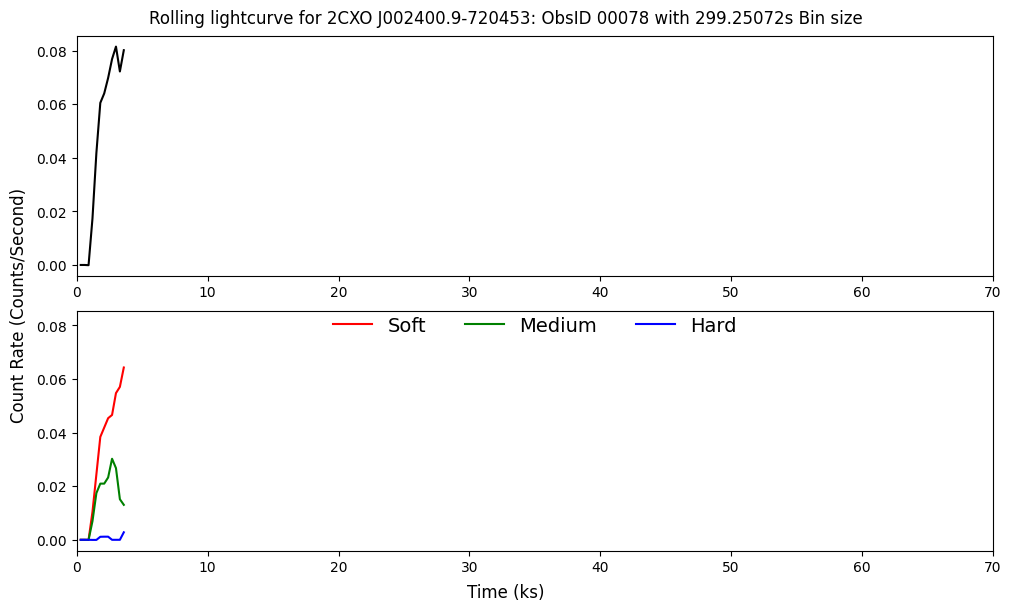

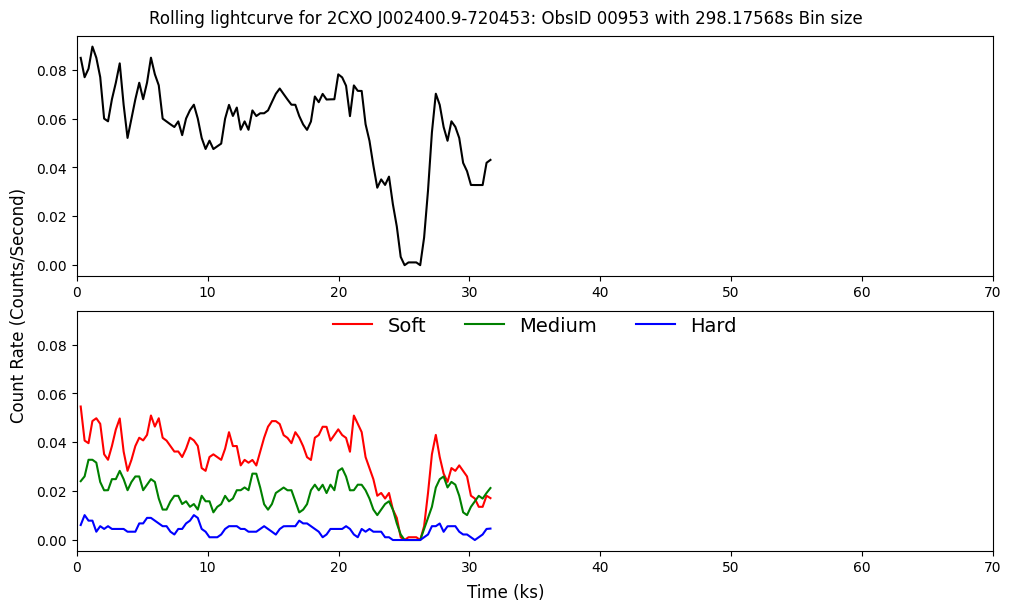

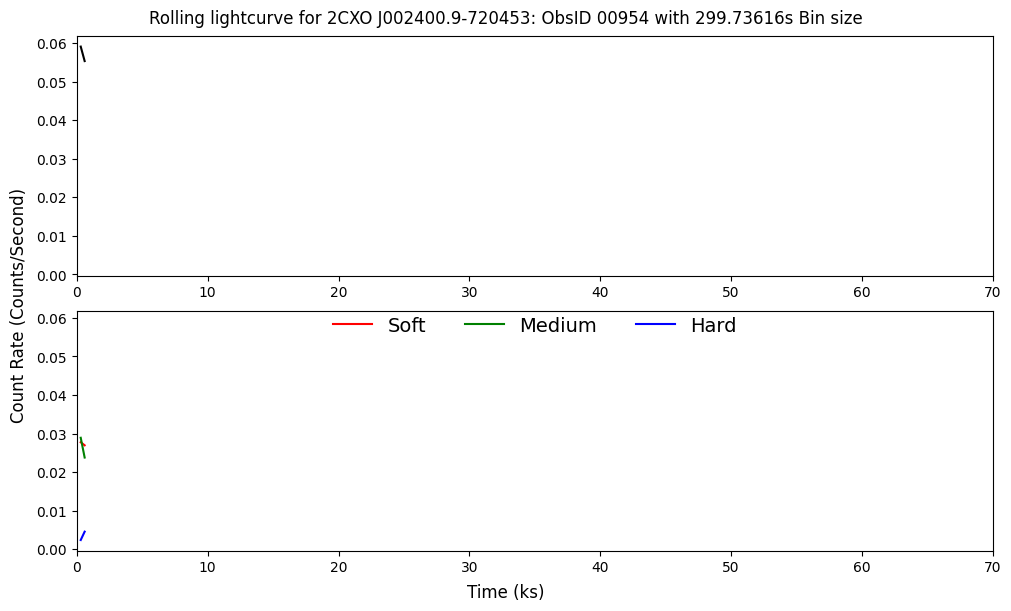

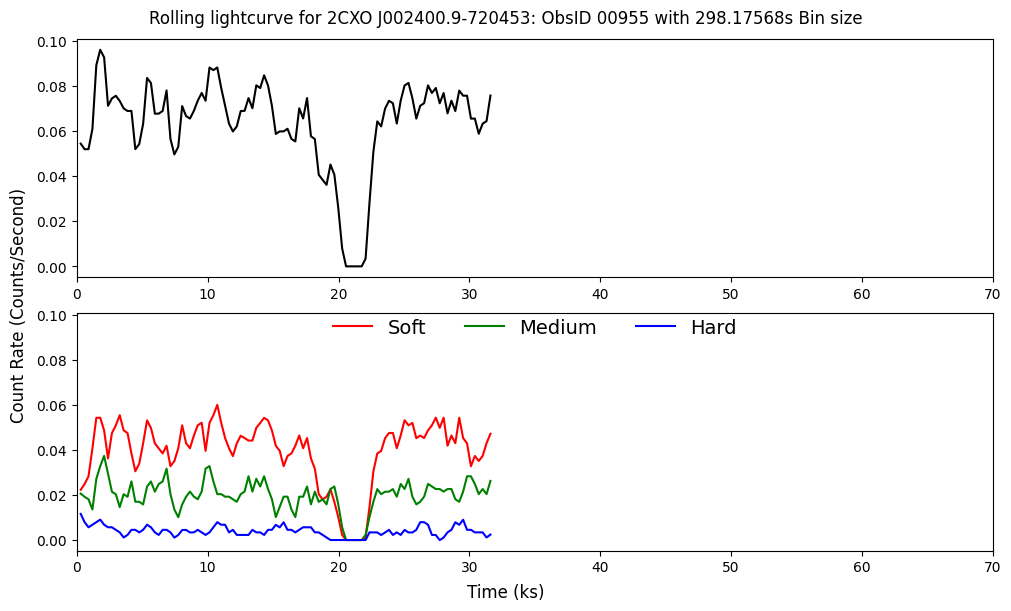

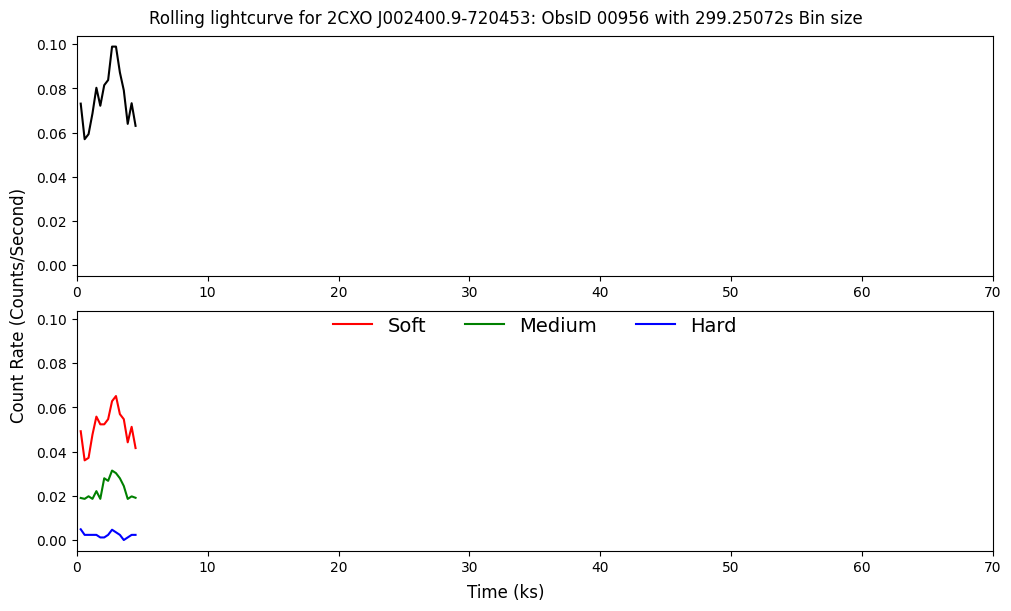

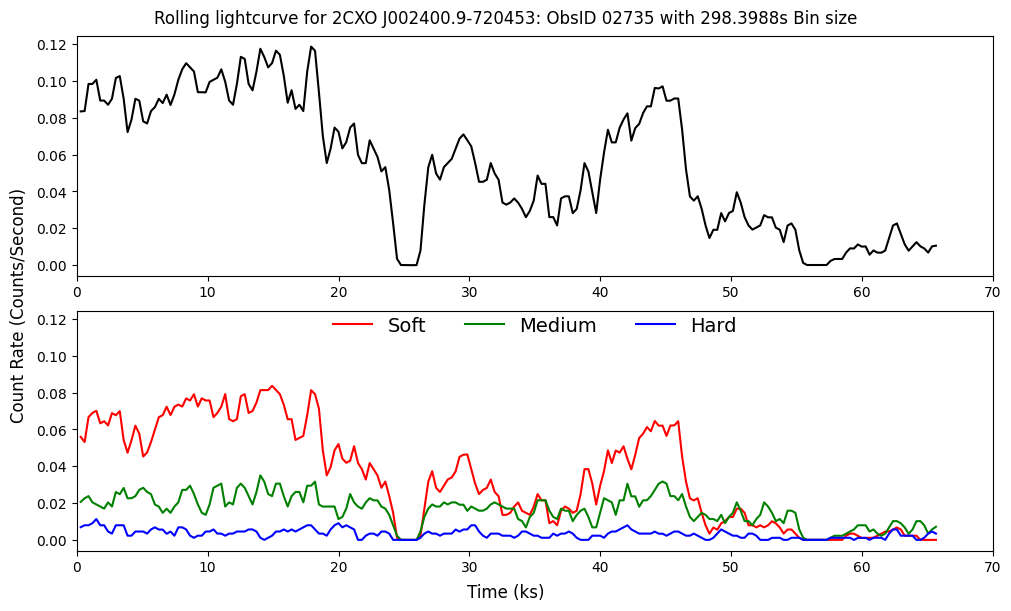

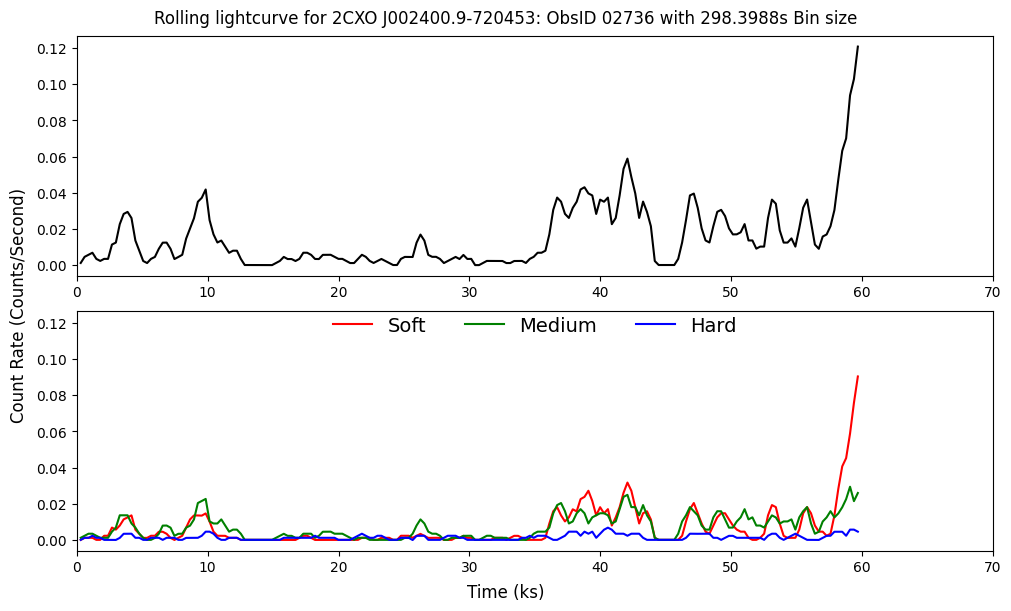

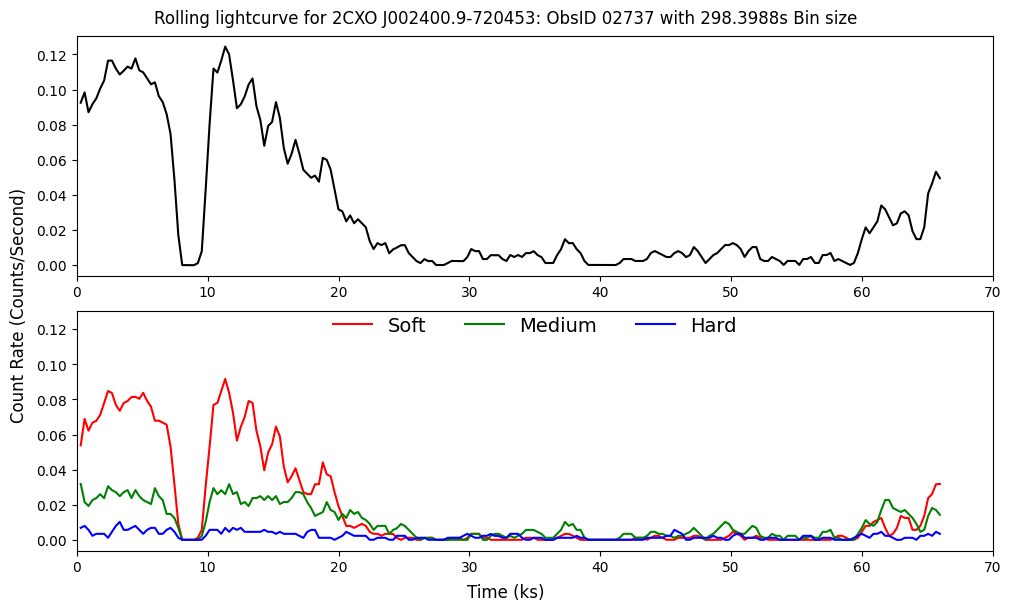

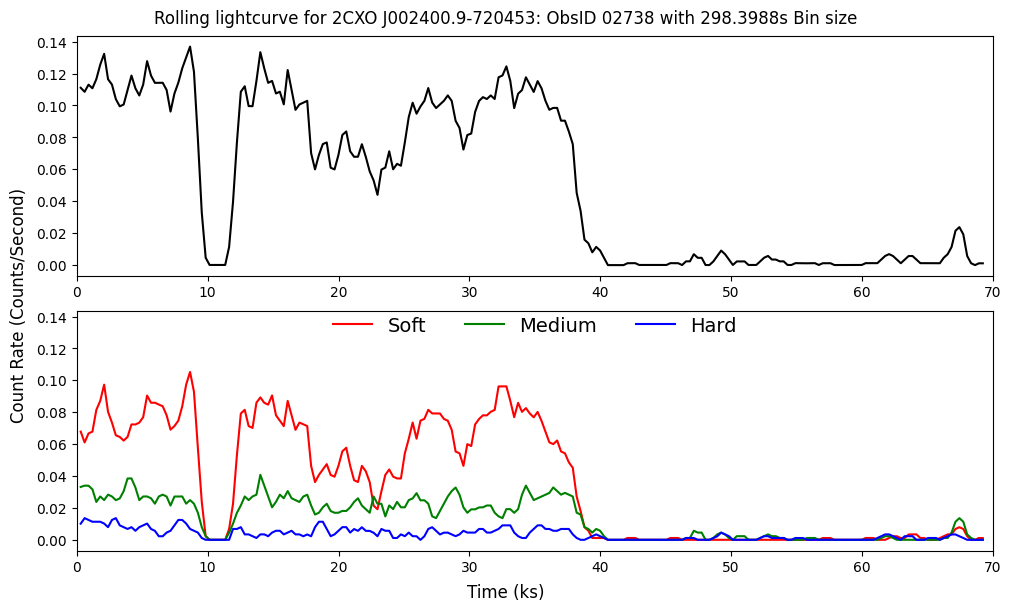

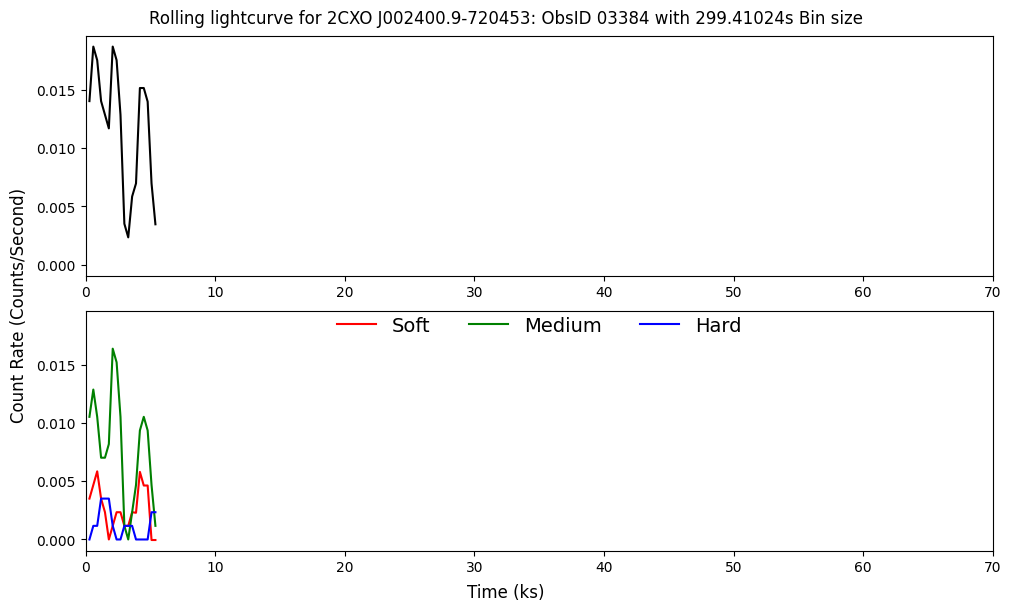

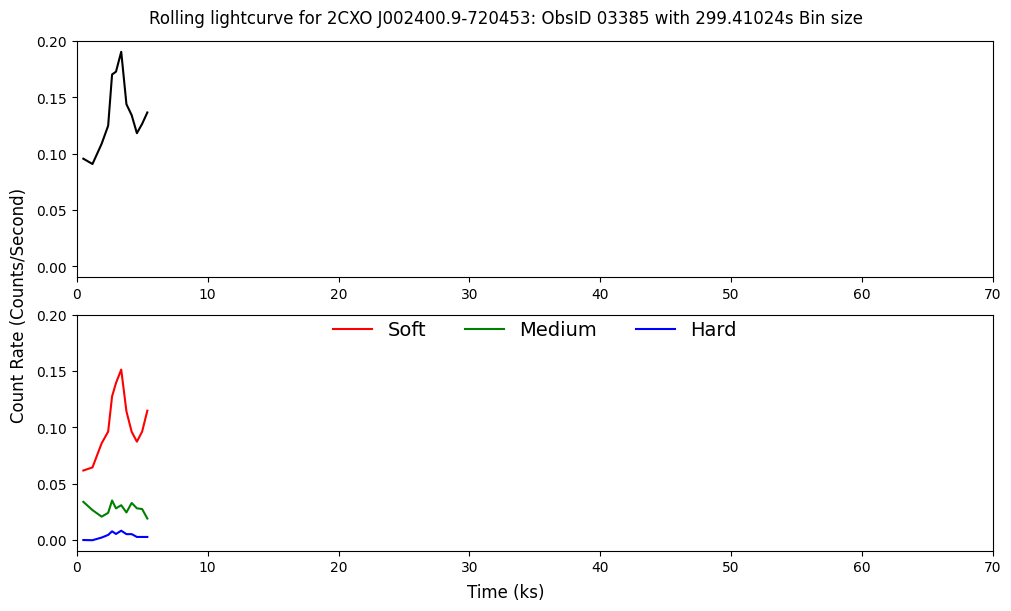

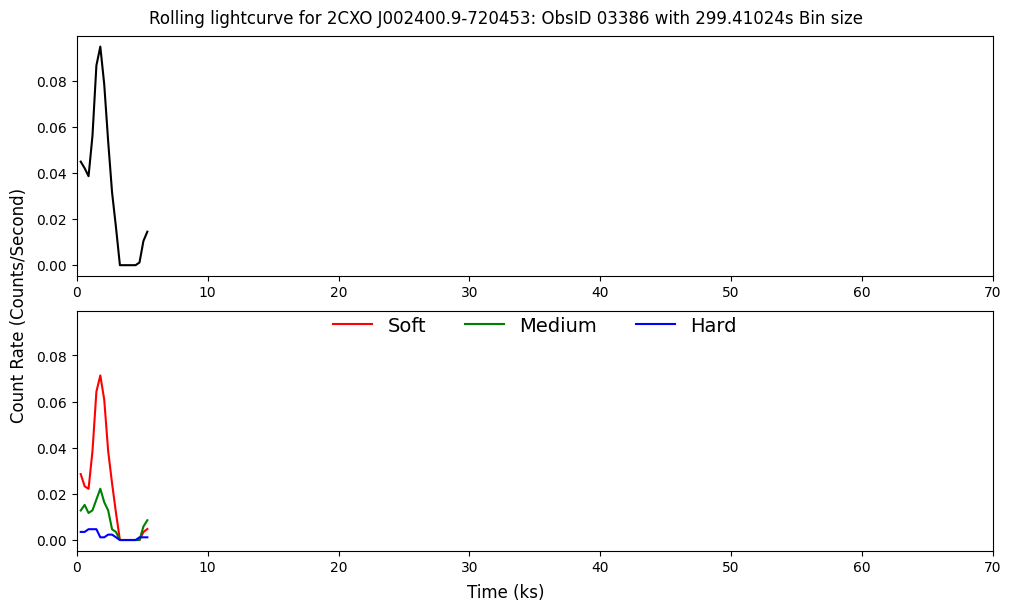

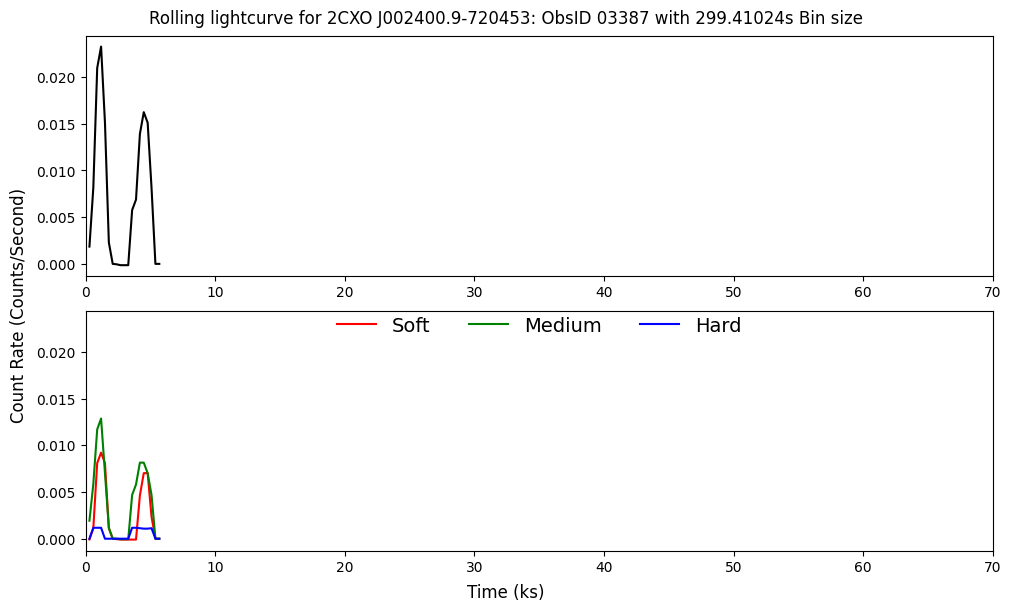

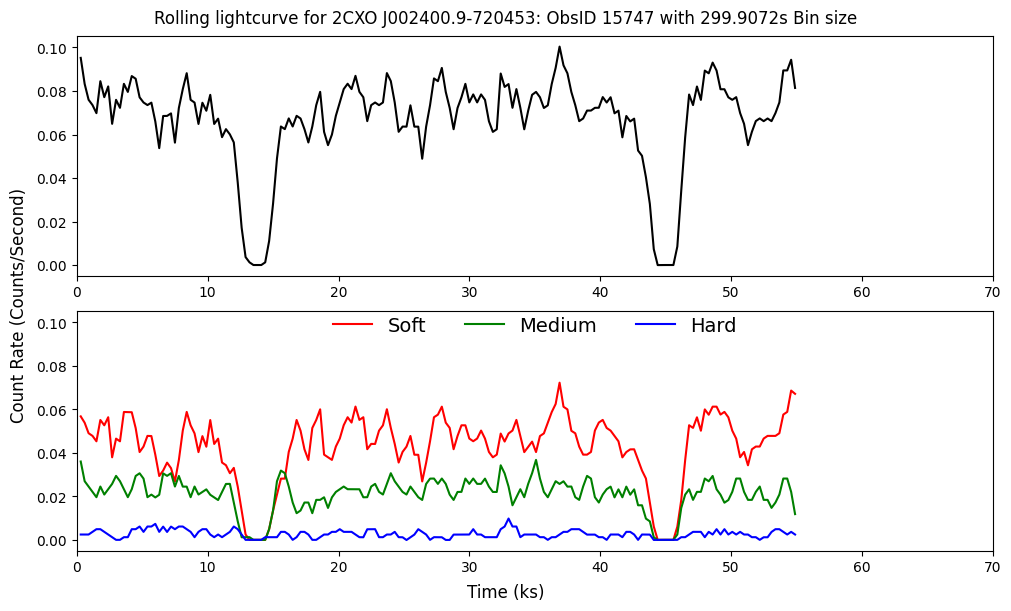

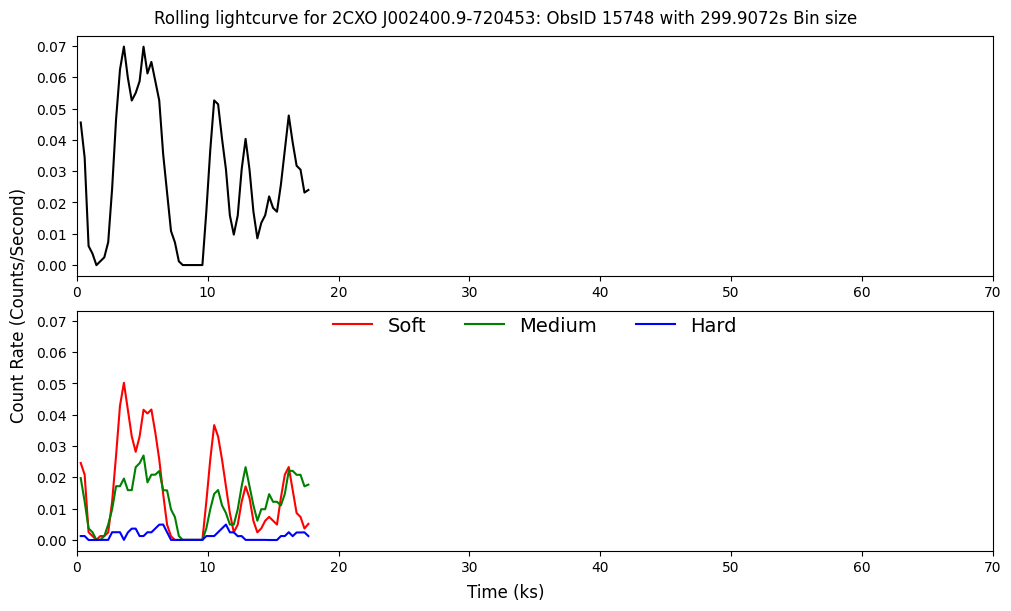

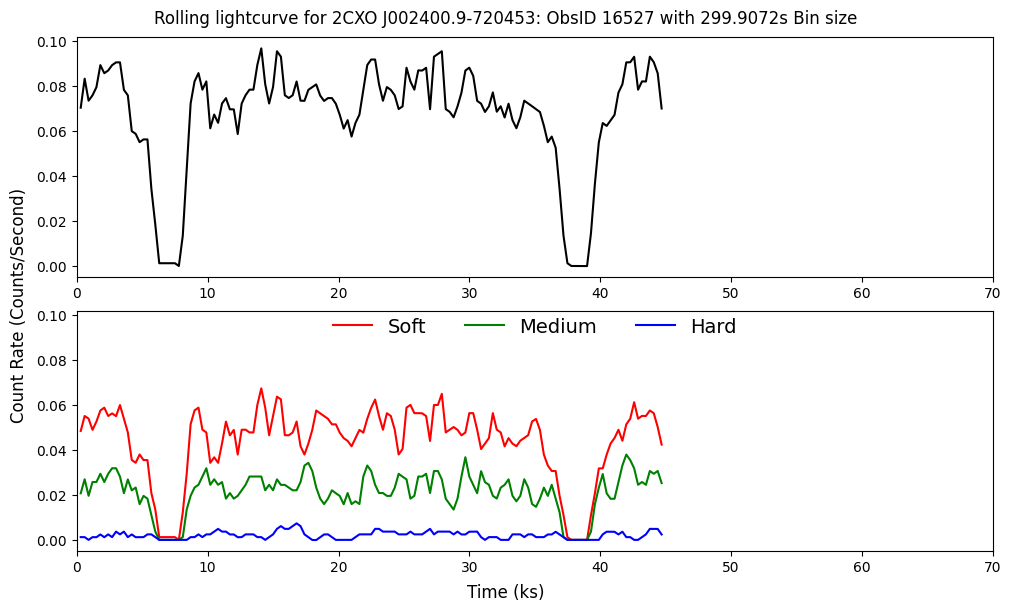

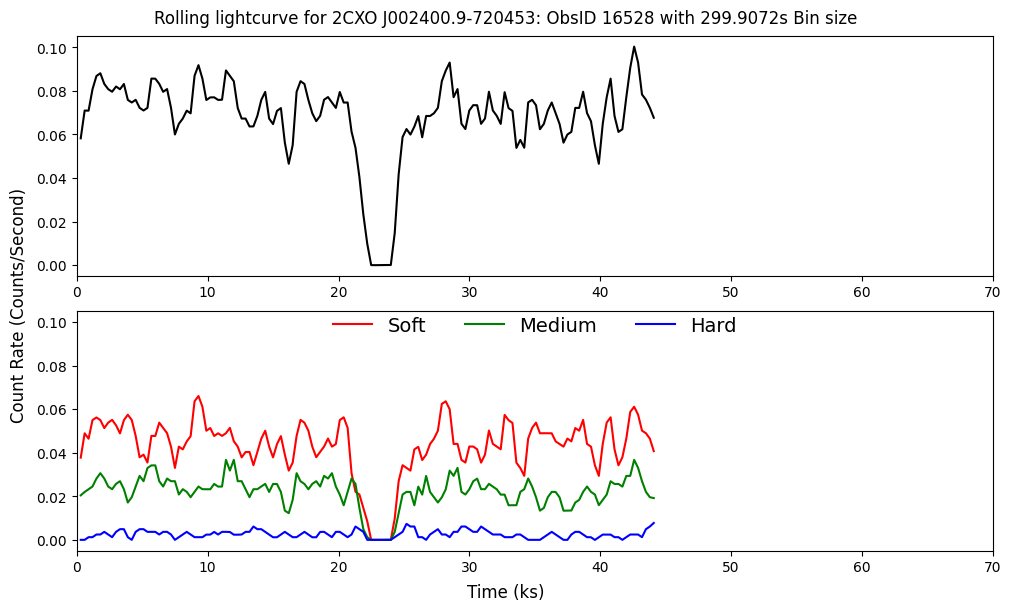

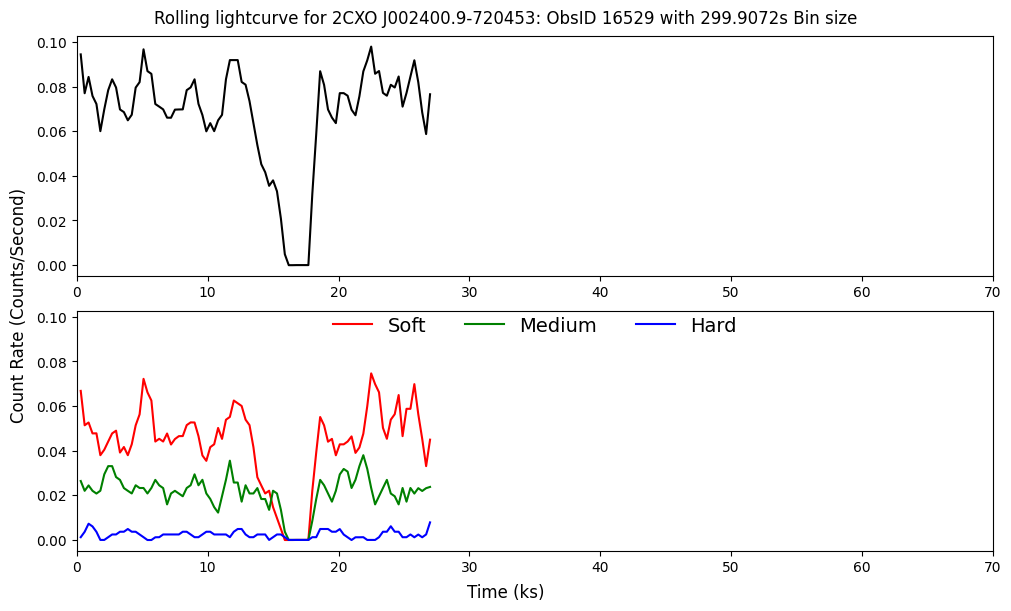

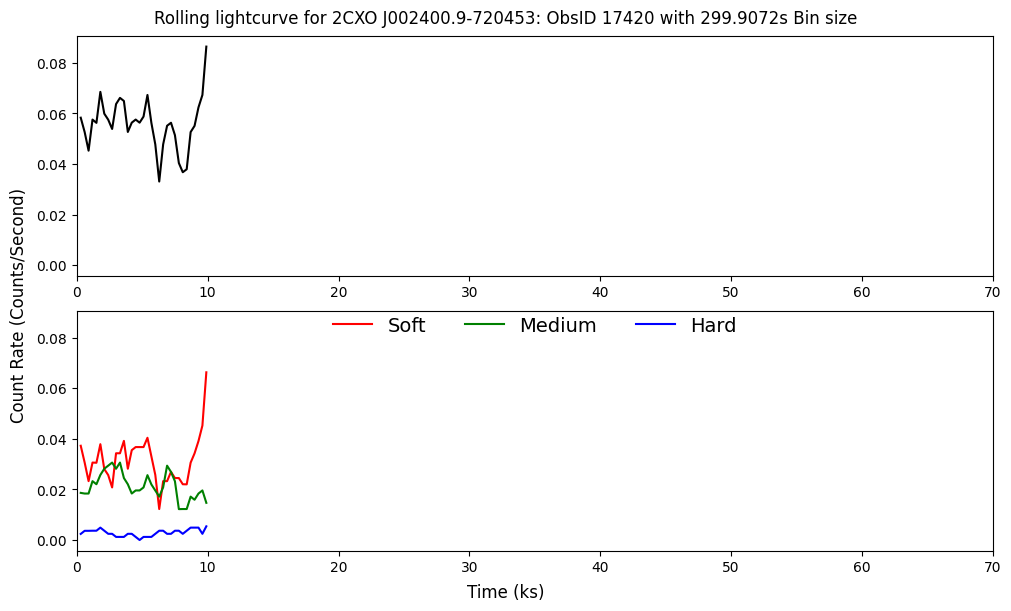

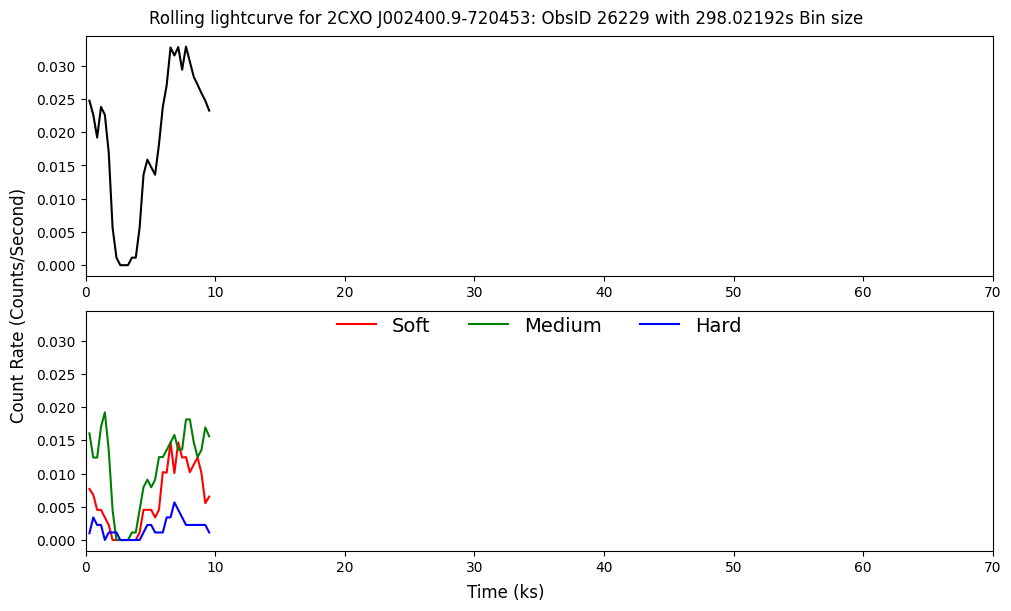

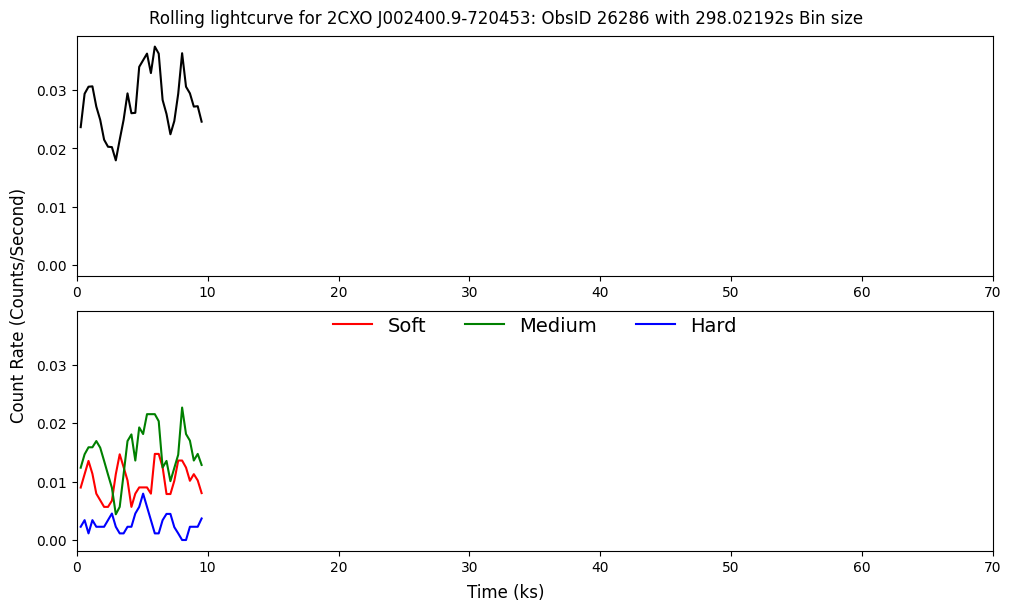

In [25]:
for file in all_files:
    broad_data = np.loadtxt(file[0])
    soft_data = np.loadtxt(file[1])
    medium_data = np.loadtxt(file[2])
    hard_data = np.loadtxt(file[3])
    bintime = np.loadtxt(file[4])

    obsid = file[0][39:44]

    data_stack = np.stack((broad_data, soft_data, medium_data, hard_data), axis=1)

    filtered = []
    for idx, data_stack_i in enumerate(data_stack):
        array = data_stack[idx]
        if array[0][4] != 0:
            filtered.append(array)
    filtered_new = np.array(filtered)

    bd = filtered_new[:,0]
    sd = filtered_new[:,1]
    md = filtered_new[:,2]
    hd = filtered_new[:,3]

    #bd[bd[:,3] < 0] = 0
    #sd[sd[:,3] < 0] = 0
    #md[md[:,3] < 0] = 0
    #hd[hd[:,3] < 0] = 0

    min_time = bd[:,0].min()
    time_data = (bd[:,0] - min_time)/1000
    
    df = pd.DataFrame({'Time': time_data, 'Net Count Rate': bd[:,1], 'Soft': sd[:,1], 'Medium': md[:,1], 'Hard': hd[:,1]})
    df_rolling = df.rolling(window=3, center=True).mean()
    rolling_std = df.rolling(window=3, center=True).std()

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), constrained_layout = True, sharey = True)
    
    axs[0].plot(df_rolling['Time'], df_rolling['Net Count Rate'], color = 'black')
    axs[0].set_xlim([0, 70])

    axs[1].plot(df_rolling['Time'], df_rolling['Soft'], color='red', label='Soft')
    axs[1].plot(df_rolling['Time'], df_rolling['Medium'], color='green', label='Medium')
    axs[1].plot(df_rolling['Time'], df_rolling['Hard'], color = 'blue', label='Hard')
    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon = False, fontsize = 14)
    axs[1].set_xlim([0, 70])

    fig.supylabel('Count Rate (Counts/Second)')
    fig.supxlabel('Time (ks)')
    fig.suptitle(f'Rolling lightcurve for 2CXO J002400.9-720453: ObsID {obsid} with {bintime}s Bin size')
    #plt.savefig(f'{source}/{directory_name}_{obsid}_reg{regid}_lc_img.png', dpi=200, bbox_inches='tight'
    plt.show()

In [ ]:
# Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()

    # Plot rolling 3-bin averaged lightcurved
    axs[1].plot(df_rolling.index/1000, df_rolling['broad_count'], color = 'red')

In [ ]:
data_stack = np.stack((broad_data, soft_data, medium_data, hard_data), axis=1)
                
                        filtered = []
                        for idx, data_stack_i in enumerate(data_stack):
                            array = data_stack[idx]
                            if array[0][4] != 0:
                                filtered.append(array)
                        filtered_new = np.array(filtered)

                        bd = filtered_new[:,0]
                        sd = filtered_new[:,1]
                        md = filtered_new[:,2]
                        hd = filtered_new[:,3]
                

                        min_time = bd[:,0].min()
                        time_data = (bd[:,0] - min_time)/1000


                        current = []
                        current_count = 0
                        for val in bd[:,3]:
                            current_count += val
                            current.append(current_count)


                            
                            

                        obsid = file[0][-41:-36]
                        regid = file[0][-26:-22]
                        soft_counts = sd[:,3]
                        medium_counts = md[:,3]
                        hard_counts = hd[:,3]

                        total_counts = soft_counts+medium_counts+hard_counts

                        
                        small_constant = 1e-6
                        hardness = (medium_counts - soft_counts) / (total_counts + small_constant)
                        df = pd.DataFrame({'Time': time_data, 'Hardness': hardness})

                        # Compute moving average with a window size of your choice
                        window_size = 5
                        df['Moving Average'] = df['Hardness'].rolling(window_size).mean()

                        fig = plt.figure(figsize=(12, 10)) # Define the figure

                        gs = fig.add_gridspec(3, 2) # Define the grid layout. We now have 4 rows and 2 columns

                        axs0 = fig.add_subplot(gs[0, :]) # Add first subplot in grid. It spans across both columns.
                        axs1 = fig.add_subplot(gs[1, :]) # Add second subplot in grid. It spans across both columns.
                        axs2 = fig.add_subplot(gs[2, 0]) # Add third subplot in grid in the left column of the third row.
                        axs3 = fig.add_subplot(gs[2, 1]) # Add fourth subplot in grid in the right column of the third row.

                        # Now you can plot using the individual axes
                        axs0.plot(time_data, bd[:,1], color = 'blue', label='Broad')
                        axs1.plot(time_data, sd[:,1], color='red', label='Soft')
                        axs1.plot(time_data, md[:,1], color='green', label='Medium')
                        axs1.plot(time_data, hd[:,1], color = 'blue', label='Hard')
                        axs2.plot(time_data, current, color = 'black', label='Cumulative Count')
                        axs3.plot(time_data, hardness, color = 'purple', label='Hardness Ratio')

                        max_y = max(abs(hardness.min()), abs(hardness.max()))

                        # Set the y-axis limits to be symmetrical around zero
                        axs3.set_ylim(-max_y, max_y)

                        # Calculate and plot moving average of hardness ratio
                        window_size = 20  # Window size for moving average
                        hardness_df = pd.DataFrame({'Time': time_data, 'Hardness': hardness})
                        hardness_df['Moving Average'] = hardness_df['Hardness'].rolling(window_size,min_periods=5).mean()
                        axs3.plot(hardness_df['Time'], hardness_df['Moving Average'], color='orange', label='Moving Average')

                        # Setting labels for each subplot
                        axs0.set_ylabel('Broad Counts', fontsize=10) 
                        axs1.set_ylabel('H-M-S Counts', fontsize=10) 
                        axs2.set_ylabel('Cumulative Counts', fontsize=10) 
                        axs3.set_ylabel('$(M-S)/T$', fontsize=10)  # LaTeX rendered text

                        axs0.tick_params(labelsize=14)  # Change the fontsize of tick labels
                        axs1.tick_params(labelsize=14)  # Change the fontsize of tick labels
                        axs2.tick_params(labelsize=14)  # Change the fontsize of tick labels
                        axs3.tick_params(labelsize=14)  # Change the fontsize of tick labels

                        axs0.set_xlim([0, max_duration])
                        axs1.set_xlim([0, max_duration])
                        axs2.set_xlim([0, max_duration])
                        axs3.set_xlim([0, max_duration])

                        fig.supxlabel('Time (ks)',fontsize=15)

                        axs0.legend()
                        axs1.legend()
                        axs2.legend()
                        axs3.legend(loc='upper right')

                        fig.supylabel('Count Rate (Counts/Second)',fontsize=15)
                        fig.suptitle(f'Source: {directory_name}: ObsID {obsid} with ~{binsize}s Bin size',fontsize=20)




                        





                        
                        os.chdir(new_directory_path)
                        fig.savefig(f"{directory_name}_{obsid}_{regid}.png")

In [ ]:
df = pd.DataFrame(broad_data)
df_new = df.loc[df[4] != 0]

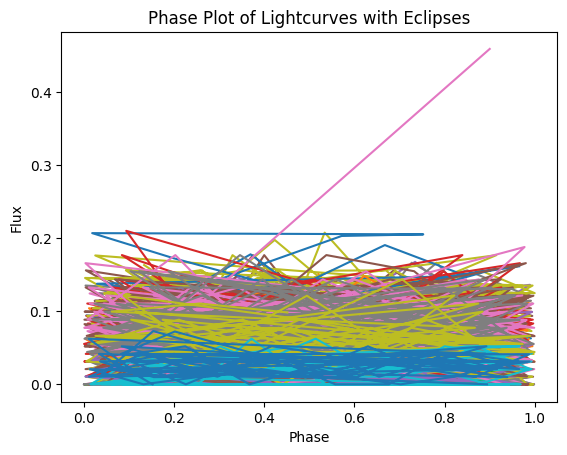

In [53]:
def calculate_phase(time, period, offset):
    return ((time - offset) % period) / period

# Assuming you have a list of file names
period = 31.2  # Period of the eclipses in ks
offset = 5.0   # Offset in ks before the first eclipse

# Initialize a list to store the data arrays
lightcurves = []

for file_name in broad_files:
    data = np.loadtxt(file_name)
    df = pd.DataFrame(data)
    df_new = df.loc[df[4] != 0] # Assuming a text file with columns: time and flux

    time = df_new[0].values
    flux = df_new[1].values
    
    phase = calculate_phase(time, period, offset)
    lightcurves.append((phase, flux))

# Create the main figure and axes
fig, ax = plt.subplots()

for phase, flux in lightcurves:
    ax.plot(phase, flux, label="Lightcurve with Eclipses")

# Set the axis labels and plot title
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')
ax.set_title('Phase Plot of Lightcurves with Eclipses')

# Add a legend to distinguish each lightcurve
#ax.legend()

# Show the plot
plt.show()
#In this code, we create a DataFrame (df) from the loaded data and then filter it to remove rows where the flux is 0. We use the .loc method with the condition df[1] != 0, assuming the flux values are stored in column index 1.

#After filtering, we extract the time and flux from the filtered DataFrame (df_filtered) and calculate the phase. We then append the phase and flux to the lightcurves list, which will be used for plotting.

#Now, when you plot the data, the phase plot will only include data points that have non-zero flux values, effectively removing the data points with flux values of 0 from the visualization.





